In [77]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot
import scipy.linalg
from scipy.linalg import sqrtm, inv
import scipy.stats
from filterpy.monte_carlo import systematic_resample
from numpy.random import uniform
from numpy.linalg import norm
from numpy.random import randn
from sklearn.metrics import mean_squared_error, r2_score
import time as tt

In [78]:
def calc_input():
    v = 1.0  # [m/s]
    yawrate = 0.1  # [rad/s]
    u = np.array([[v, yawrate]]).T
    return u

In [79]:
def motion_model(x, u):
    F = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0],
    ])

    B = np.array([
        [np.cos(x[2])[0], 0],
        [np.sin(x[2])[0], 0],
        [0, dt],
        [1, 0],
    ])
    
    x = F.dot(x) + B.dot(u)
    
    return x

In [80]:
def observation(xTrue, xd, u, efk=True):
    if efk:
        xTrue = motion_model(xTrue, u)

        # add noise to GPS x-y
        zx = xTrue[0, 0] + np.random.randn() * GPS_Noise[0, 0]
        zy = xTrue[1, 0] + np.random.randn() * GPS_Noise[1, 1]
        z = np.array([[zx, zy]])
    
        # add noise to input
        ud1 = u[0, 0] + np.random.randn() * Input_Noise[0, 0]
        ud2 = u[1, 0] + np.random.randn() * Input_Noise[1, 1]
        ud = np.array([[ud1, ud2]]).T
    
        xd = motion_model(xd, ud)
    
        return xTrue, z, xd, ud
    
    else:
        xTrue = motion_model(xTrue, u)
    
        # add noise to gps x-y
        z = observation_model(xTrue) + GPS_Noise @ np.random.randn(2, 1)
    
        # add noise to input
        ud = u + Input_Noise @ np.random.randn(2, 1)
    
        xd = motion_model(xd, ud)
    
        return xTrue, z, xd, ud

In [81]:
def observation_model(x):
    H = np.array([
        [1.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0]
    ], dtype=float)
    
    z = H @ x
    return z

In [82]:
def ekf_estimation(xEst, PEst, z, u):
    def jacobH(x):
        # Jacobian of Observation Model
        return np.array([
            [1.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0]
        ], dtype=float)
    
    def jacobF(x, u):
        v = u[0][0]
        phi = x[2][0]
        
        # Jacobian of Motion Model
        return np.array([
            [1.0, 0.0, -v * np.sin(phi) * dt, np.cos(phi) * dt],
            [1.0, 0.0, v * np.cos(phi) * dt, np.sin(phi) * dt],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0]
        ], dtype=float)
    
    # Predict
    xPred = motion_model(xEst, u)
    pPred = jacobF(xEst, u) @ PEst @ jacobF(xEst, u).T + Q

    # Update
    jacobiana = jacobH(xPred)
    zPred = observation_model(xEst)
    y = z.T - zPred
    S = jacobiana @ pPred @ jacobiana.T + R
    S = S.astype(float)
    S_inv = np.linalg.inv(S)
    K = pPred @ jacobiana.T @ S_inv
    xEst = xPred + K @ y
    PEst = (np.eye(len(xEst)) - K @ jacobiana) @ pPred

    return xEst, PEst

In [83]:
def setup_ukf(nx):
    # calculate lambda
    lamb = ALPHA ** 2 * (nx + KAPPA) - nx
    # calculate the weights
    # w^(0)
    wm = [lamb / (lamb + nx)] # wm corresponds to w of the UKF Algorithm
    # wc^(0)
    wc = [(lamb / (lamb + nx)) + (1 - ALPHA ** 2 + BETA)]
    for i in range(2 * nx):
        # w^(+-i)
        wm.append(1.0 / (2 * (nx + lamb)))
        # wc^(+-i)
        wc.append(1.0 / (2 * (nx + lamb)))
    
    # define gamma
    gamma = math.sqrt(nx + lamb)

    wm = np.array([wm])
    wc = np.array([wc])

    return wm, wc, gamma

In [84]:
def ukf_estimation(xEst, PEst, z, u, wm, wc, gamma):
    def generate_sigma_points(xEst, PEst, gamma):
        # Calculate the sigma points using xEst (xhat_k|k), PEst (P_k|k) and gamma
        # or using xPred (xhat_k|k-1), PPred (P_k|k-1) and gamma

        x_0 = xEst

        sigma_neg = xEst - gamma * sqrtm(PEst)
        sigma_pos = xEst + gamma * sqrtm(PEst)

        return np.concatenate((x_0, sigma_neg, sigma_pos), axis=1)
    
    def predict_sigma_motion(sigma, u):
        # Sigma Points prediction with motion model
        return motion_model(sigma, u)
    
    def predict_sigma_observation(sigma):
        # Sigma Points prediction with observation model
        return observation_model(sigma)
    
    def calc_sigma_covariance(x, sigma, wc, Pi):
        # Calculate the covariance P = PPred (P_k|k-1) using x = xPred (xhat_k+1|k),
        # sigma (x^(i)_k+1|k), wc and Pi = Q (initial value of PPred)
        # or calculate the covariance P = st (P^yy_t|t-1) using x = zb (yhat_t),
        # sigma = z_sigma (y^(i)_t), wc and Pi = R (initial value of st)
        return wc * (sigma-x) @ (sigma-x).T + Pi 
    
    def calc_pxz(sigma, x, z_sigma, zb, wc):
        # Calculate the covariance Pxz (P^xy_t|t-1) using wc, sigma (x^(i)_t|t-1),
        # x (xhat_t|t-1), z_sigma (y^(i)_t) and zb (yhat_t) and 
        return wc * (sigma-x) @ (z_sigma-zb).T
    
    #  Predict (UKF - time update)
    
    # Calculate the sigma-points using xExt (xhat_k|k) and PEst (P_k|k)
    # and gamma in def generate_sigma_points
    sigma = generate_sigma_points(xEst, PEst, gamma)
    
    # Propagate the sigma-points (x^(i)_k+1|k = f(x^(i)_k|k , w^(i)_k)) 
    # using the sigma-points obtained in the previous calculus and u (ud = noisy u)
    # in def predict_sigma_motion
    sigma_propagated = predict_sigma_motion(sigma, u)

    # Calculate xPred (xhat_k+1|k) using wm and the propagated sigma-points 
    xPred = wm @ sigma_propagated.T  
    xPred = xPred.T
    
    # Calculate PPred (P_k|k-1) using xPred, the propagated sigma-points
    # wc and Q in def calc_sigma_covariance
    PPred = calc_sigma_covariance(xPred, sigma_propagated, wc, Q)

    
    #  Update (UKF - measurement update)
    
    # Calculate zPred (yhat_t) using xPred (xhat_k+1|k) in def observation_model
    zPred = observation_model(xPred)
    
    # Calculate y = (y_t - yhat_t) using z (y_t) and zPred (yhat_t)
    y = z - zPred
     
    # Calculate the sigma-points using xPred (xhat_k|k-1), PPred (P_k|k-1)
    # and gamma in def generate_sigma_points
    sigma = generate_sigma_points(xPred, PPred, gamma)
    
    # Propagate the sigma-points z_sigma (y^(i)_t = h(x^(i)_t|t-1 , e^(i)_t)) 
    # using the propagated sigma-points in def predict_sigma_observation
    z_sigma = predict_sigma_observation(sigma)
    
    # Calculate zb (yhat_t) using wm and the propagated sigma-points z_sigma
    zb = wm @ z_sigma.T
    zb = zb.T
    
    # Calculate the sigma covariance, st (P^yy_t|t-1), using zb (yhat_t),
    # z_sigma (y^(i)_t), wc and R in def calc_sigma_covariance
    st = calc_sigma_covariance(zb, z_sigma, wc, R.T)
    
    # Calculate Pxz (P^xy_t|t-1) using sigma (x^(i)_t|t-1), xPred (xhat_t|t-1),
    # z_sigma (y^(i)_t), zb (yhat_t) and wc in def calc_pxz
    Pxz = calc_pxz(sigma, xPred, z_sigma, zb, wc)    
    
    # Calculate K_t using Pxz (P^xy_t|t-1) and st (P^yy_t|t-1)
    K_t = Pxz @ inv(st.astype(float))
    
    # Update xEst (Xhat_t|t) using xPred (xhat_t|t-1), K_t and y (y_t - yhat_t)
    xEst = xPred + K_t @ y
    
    # Update PEst (P_t|t) using PPred (P_t|t-1), K_t and st (P^yy_t|t-1)
    PEst = PPred - K_t @ st @ K_t.T
    
    return xEst, PEst

In [85]:
def plot_covariance_ellipse(xEst, PEst):
    Pxy = PEst[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    a = math.sqrt(eigval[bigind])
    b = math.sqrt(eigval[smallind])
    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eigvec[bigind, 1], eigvec[bigind, 0])
    R = np.array([[math.cos(angle), math.sin(angle)],
                  [-math.sin(angle), math.cos(angle)]])
    fx = R.dot(np.array([[x, y]]))
    px = np.array(fx[0, :] + xEst[0, 0]).flatten()
    py = np.array(fx[1, :] + xEst[1, 0]).flatten()
    plt.plot(px, py, "--r")

In [86]:
# Estimation parameters of EKF
Q = np.diag([0.1, 0.1, np.deg2rad(1.0), 1.0])**2  # predict state covariance
R = np.diag([1.0, 1.0])**2  # Observation x,y position covariance

#  Simulation parameter
GPS_Noise = np.diag([0.5, 0.5])**2
Input_Noise = np.diag([1.0, np.deg2rad(30.0)])**2

dt = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]

#  UKF Parameter
ALPHA = 0.001
BETA = 2
KAPPA = 0

show_animation = False

In [87]:
from numpy.random import uniform

def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

In [88]:
def predict(particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist

In [89]:
def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

In [90]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

In [91]:
def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)

In [92]:
def neff(weights):
    return 1. / np.sum(np.square(weights))

In [93]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

In [94]:
def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [95]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [96]:
def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

In [97]:
def test_number_particles():
    times = []
    dt_number_particles = 1
    
    N = 1000

    # Particles
    landmarks = np.zeros((100, 2))

    # create particles and weights
    particles = create_uniform_particles((0, 200), (-100, 100), (0, 6.28), N)
    weights = np.ones(N) / N   

    xs = []
    robot_pos = np.array([0., 0.])
    sensor_std_err = 0.5

    for i in range(50):
        start = tt.time()
        time = 0.0
        
        # State Vector [x y yaw v]'
        xEst = np.zeros((4, 1))
        xTrue = np.zeros((4, 1))
        PEst = np.eye(4)
    
        xDR = np.zeros((4, 1))  # Dead reckoning
    
        # history
        hxTrue = xTrue
        hxDR = xTrue
        hxmu = np.array(xTrue[:2])
        hz = np.zeros((1, 2))
        while SIM_TIME >= time:
            app_x = np.random.randint(0, 61)
            app_y = np.random.randint(0, 21)
            aux = np.array([app_x, app_y])
            landmarks[i] = aux
            NL = len(landmarks)

            time += dt_number_particles
            u = calc_input()

            xTrue, z, xDR, ud = observation(xTrue, xDR, u)

            # store data history
            hxDR = np.hstack((hxDR, xDR))
            hxTrue = np.hstack((hxTrue, xTrue))
            hz = np.vstack((hz, z))

            # print(z)
            robot_pos = z

            zs = (norm(landmarks - robot_pos, axis=1) + (randn(NL) * sensor_std_err))

            predict(particles, u=(0.00, 1.414), std=(.2, .05))

            # incorporate measurements
            update(particles, weights, z=zs, R=sensor_std_err, 
                   landmarks=landmarks)

            # resample if too few effective particles
            if neff(weights) < N/2:
                indexes = systematic_resample(weights)
                resample_from_index(particles, weights, indexes)
                assert np.allclose(weights, 1/N)
            mu, var = estimate(particles, weights)

            hxmu = np.hstack((hxmu, np.array([mu]).T))
            
        plt.figure(figsize=(10, 10))
        plt.title("Number of Particles: " + str(i + 1))

        plt.scatter(landmarks[:, 0], landmarks[:, 1], color='brown', marker="D", label="Landmarks")
        plt.plot(hz[:, 0], hz[:, 1], ".g",label="GPS Signal")
        plt.plot(hxTrue[0, :].flatten(), hxTrue[1, :].flatten(), "-b",label="True Position")
        plt.plot(hxDR[0, :].flatten(), hxDR[1, :].flatten(), "-k",label="Dead-Reckoning")
        
        plot_covariance_ellipse(xEst, PEst)
    
        plt.axis("equal")
        plt.grid(True)
        plt.plot(hxmu[0, :].flatten(), hxmu[1, :].flatten(), "-y",label="Particle Filter")
        plt.legend()
        plt.show()
        times.append(tt.time() - start)
        
    plt.figure(figsize=(10, 10))
    plt.title("Time for each number of landmarks")
    plt.plot(list(range(1, len(times) + 1)), times)
    plt.xlabel("Number of landmarks")
    plt.ylabel("Time (s)")
    plt.grid(True)
    plt.show()

In [98]:
def main_2():
    nx = 4  # State Vector [x y yaw v]'

    xEst = np.zeros((nx, 1))
    xTrue = np.zeros((nx, 1))
    PEst = np.eye(nx)

    wm, wc, gamma = setup_ukf(nx)

    xDR = np.zeros((nx, 1))  # Dead reckoning

    # history
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue
    hz = np.zeros((2, 1))
    
    time = 0.0
    
    while SIM_TIME >= time:
        time += dt
        # effective values of the input variables (v and omega)
        u = calc_input()
        
        # xTrue: x_k|k-1 (given by the motion_model using x and u)
        # z: noisy GPS output variables (given by observation_model)
        # xDR: xDR_k|k-1 (given by the motion_model using xDR_k-1 and noisy u)
        # ud: noisy u
        xTrue, z, xDR, ud = observation(xTrue, xDR, u, False)

        # Estimation of xEst, PEst using the UKF algorithm 
        xEst, PEst = ukf_estimation(xEst, PEst, z, ud, wm, wc, gamma)

        # store data history
        hxEst = np.hstack((hxEst, xEst))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))        
        hz = np.vstack((hz, z))
        
    return hxEst

In [99]:
def main(seed=False):
    if seed:
        np.random.seed(seed)
    time = 0.0

    # State Vector [x y yaw v]'
    xEst = np.zeros((4, 1))
    xTrue = np.zeros((4, 1))
    PEst = np.eye(4)

    xDR = np.zeros((4, 1))  # Dead reckoning
    
    # history
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue
    hxmu = np.array(xTrue[:2])
    hz = np.zeros((1, 2))
    
    N = 1000  # Number of particles

    # Landmarks
    landmarks = np.array([[0, 0],[100, 100],[0, 200],[-100, 100]])
    NL = len(landmarks)


    # create particles and weights

    particles = create_uniform_particles((0,40), (0,40), (0, 6.28), N)
    weights = np.ones(N) / N   

    xs = []
    robot_pos = np.array([0., 0.])
    sensor_std_err = 0.5

    while SIM_TIME >= time:
        time += dt
        u = calc_input()

        xTrue, z, xDR, ud = observation(xTrue, xDR, u)
        xEst, PEst = ekf_estimation(xEst, PEst, z, ud)

        # store data history

        hxEst = np.hstack((hxEst, xEst))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))
        hz = np.vstack((hz, z))

        robot_pos = z

        zs = (norm(landmarks - robot_pos, axis=1) + (randn(NL) * sensor_std_err))

        predict(particles, u=(0.00, 1.414), std=(.2, .05))
        
        # incorporate measurements
        update(particles, weights, z=zs, R=sensor_std_err, 
               landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        mu, var = estimate(particles, weights)

        hxmu = np.hstack((hxmu, np.array([mu]).T))
        
    hxEst_2 = main_2()

    plt.figure(figsize=(12, 12))

    plt.scatter(landmarks[:, 0], landmarks[:, 1], color='brown', marker="D", label="Landmarks")
    plt.plot(hz[:, 0], hz[:, 1], ".g",label="GPS Signal")
    plt.plot(hxTrue[0, :].flatten(), hxTrue[1, :].flatten(), "-b",label="True Position")
    plt.plot(hxDR[0, :].flatten(), hxDR[1, :].flatten(), "-k",label="Dead-Reckoning")
    plt.plot(hxEst[0, :].flatten(), hxEst[1, :].flatten(), "-r", label="EKF")
    plt.plot(hxEst_2[0, :].flatten(), hxEst_2[1, :].flatten(), "-m", label="UKF")
    
    plot_covariance_ellipse(xEst, PEst)
    
    plt.axis("equal")
    plt.grid(True)
    plt.plot(hxmu[0, :].flatten(), hxmu[1, :].flatten(), "-y",label="Particle Filter")
    plt.legend()
    plt.show()
    
    return mse(hxTrue.T[:, :2], hxDR.T[:, :2]), rmse(hxTrue.T[:, :2], hxDR.T[:, :2]), r2(hxTrue.T[:, :2], hxDR.T[:, :2]), mse(hxTrue.T[:, :2], hxEst.T[:, :2]), rmse(hxTrue.T[:, :2], hxEst.T[:, :2]), r2(hxTrue.T[:, :2], hxEst.T[:, :2]), mse(hxTrue.T[:, :2], hxEst_2.T[:, :2]), rmse(hxTrue.T[:, :2], hxEst_2.T[:, :2]), r2(hxTrue.T[:, :2], hxEst_2.T[:, :2]), mse(hxTrue.T[:, :2], hxmu.T), rmse(hxTrue.T[:, :2], hxmu.T), r2(hxTrue.T[:, :2], hxmu.T)

# Relatório

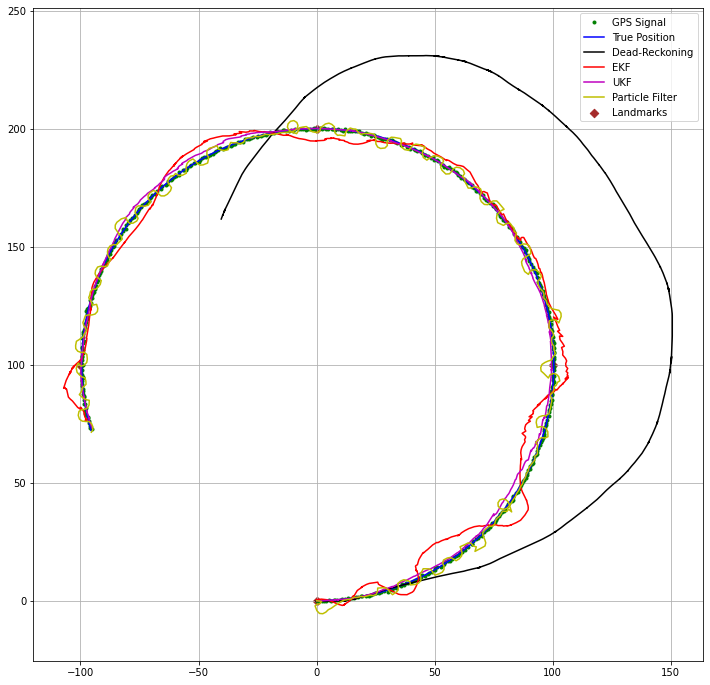

In [100]:
main(91235)  # True position, dead-reckoning, ekf, ukf, particle filter
print('')

### Dead-Reckoning
<p>O algoritmo de Dead-Reckoning calcula a posição atual usando a posição anterior e incorporando as estimações de velocidade e direção ao longo do tempo.<br> Como seria de esperar, as suas estimações são fracas e apenas consegue ter resultados razoáveis para um número baixo de movimentos.</p>

### Extended Kalman Filter
<p>O Extended Kalman Filter é uma versão não-linear do Kalman Filter, isto é, funciona do mesmo modo que o Kalman Filter mas aplica-se a sistemas não-lineares.<br>Este algoritmo trata de converter o sistema não-linear a um sistema linear (através de matrizes jacobianas), para depois prever os valores tal como é feito no Kalman Filter.</p>

### Unscented Kalman Filter
<p>O Unscented Kalman Filter é também um algoritmo para modelos não-lineares, contudo, são geralmente mais precisos, pois são gerados sigma-points (SP) e respetivos pesos, que depois de sofreram as transformações que o modelo real sofreu, acabam a ser mais próximos da realidade, seguindo também aproximadamente uma distribuição gaussiana.<br>Depois, apenas trata de prever os valores tal como no Kalman Filter.</p>

### Particle Filter

<p>O Filtro de Partículas, ao contrário dos algoritmos apresentados anteriormente que determinam o movimento do robot através de previões e comparações com dados reais, este algoritmo gera vários pontos e aplica o mesmo movimento até chegar à posição real do robot. Segue-se uma descrição mais detalhada do algoritmo:</p>
<ol>
    <li>Começamos por criar alguns pontos de referência para fazer comparações</li>
    <li>De seguida, são geradas várias partículas em posições aleatórias no espaço de procura. Todas as partículas têm a mesma probabilidade de estar no sítio certo.</li>
    <li>É então comparada a posição real (obtida de dados GPS por exemplo) com todas as partículas geradas (através da distâncias aos nossos pontos de referência) e as partículas que tiverem em posições semelhantes, terão assim um maior peso.</li>
    <li>Nas posições onde concluímos que é mais provável corresponder à realidade, geramos novas partículas nessas regiões.</li>
    <li>O robot move-se e aplicamos o mesmo movimento às partículas.</li>
    <li>A partir daqui, repetimos os passos 3, 4 e 5.</li>
    <li>Ao longo do tempo, a tendência das partículas é aproximarem-se da realidade.</li>
</ol>

<p><b>Nota</b>: o código desenvolvimento foi obtido com base neste <a link=https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb>notebook</a></p>

<p>Para este filtro, testei variar o número de pontos de referência (1 a 50) e o que esperava era que com o aumento do número de partículas, o erro entre o previsto e o real diminuisse e o tempo de cada iteração aumentasse.<br>Contudo, pela análise dos gráficos, conseguimos perceber que não foi isso que aconteceu nos testes: as previões do filtro foram aleatórias e não tinha relação com o número de pontos de referência criados (em algumas situações, os resultados são semelhantes para muitos ou poucos pontos de referência), contudo, o aumento do tempo é notório.</p>

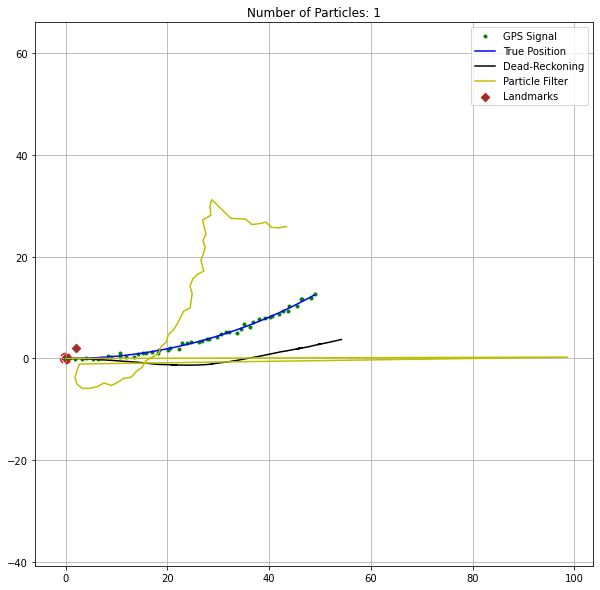

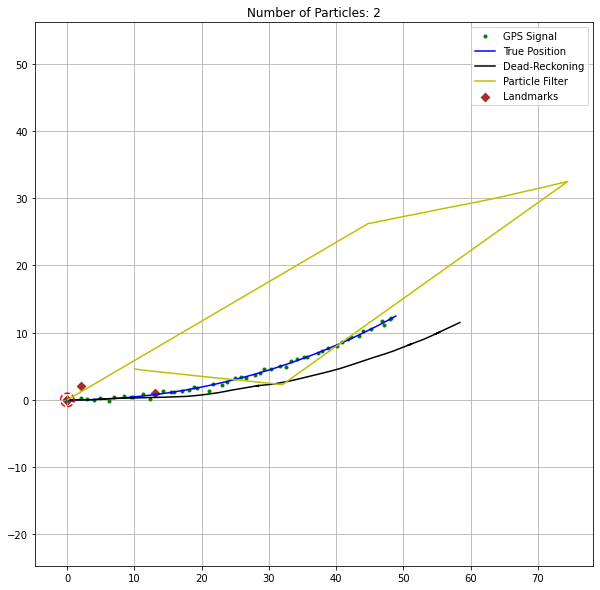

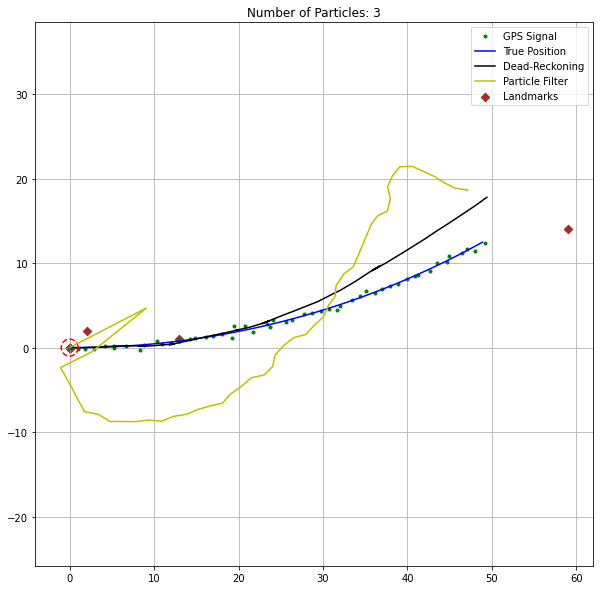

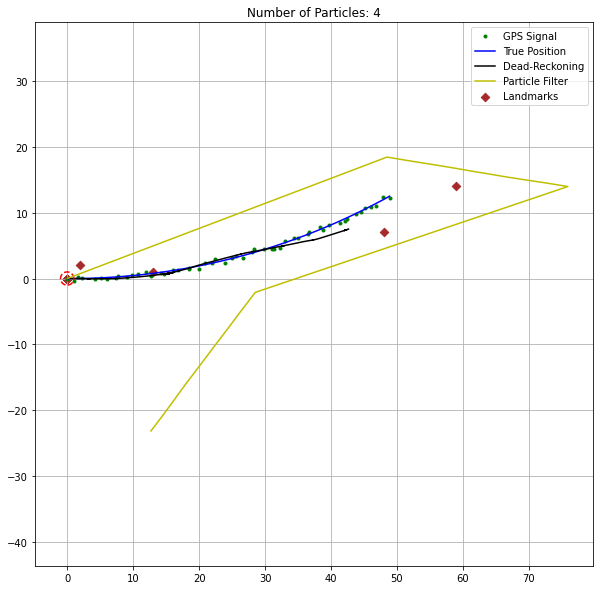

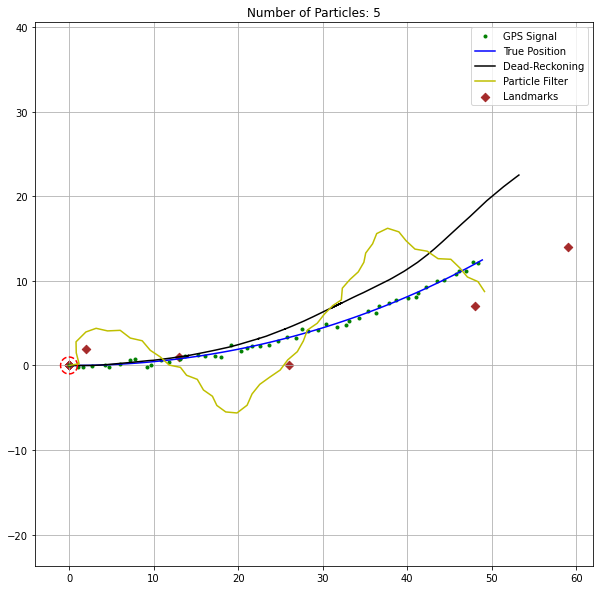

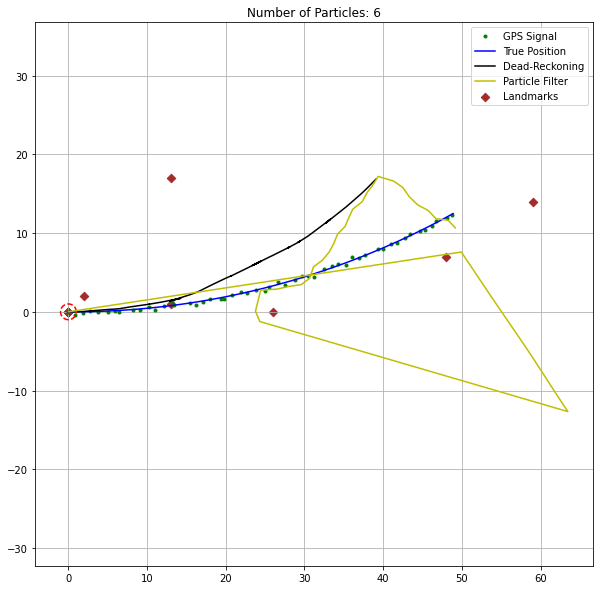

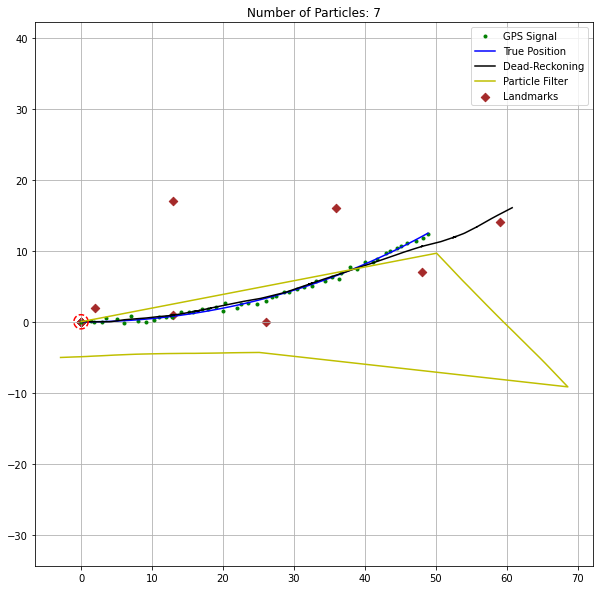

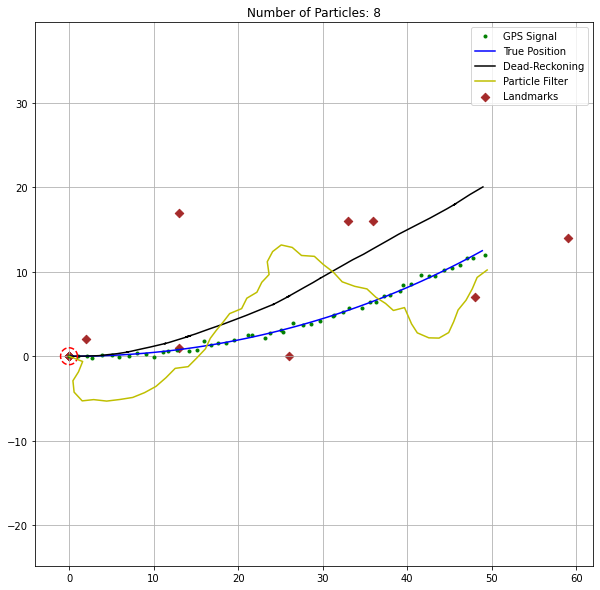

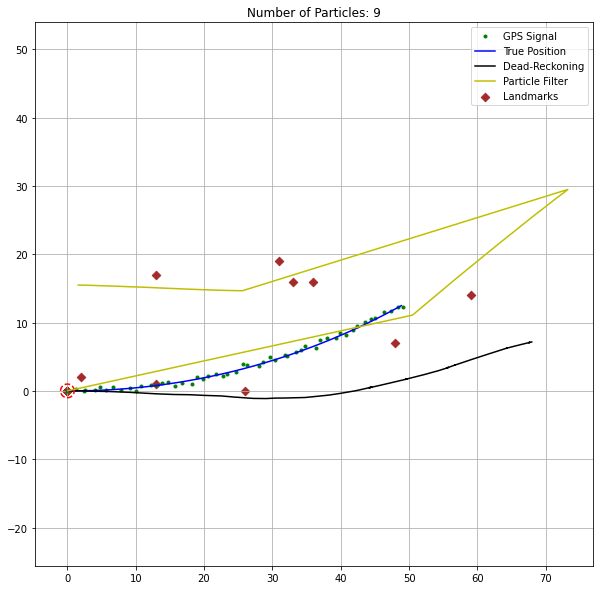

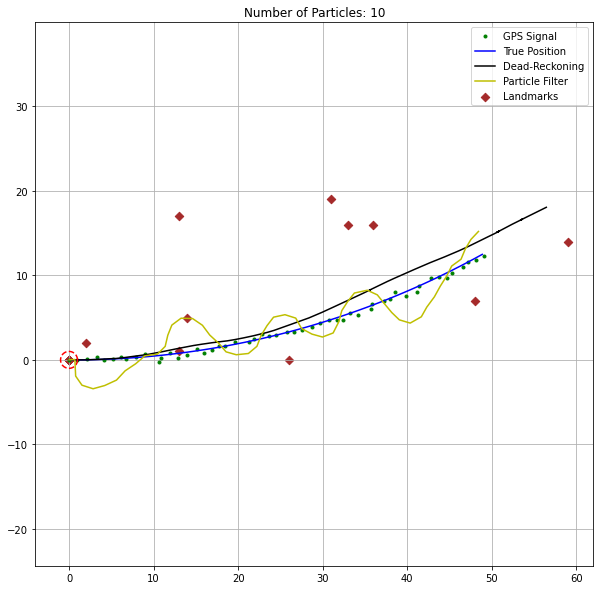

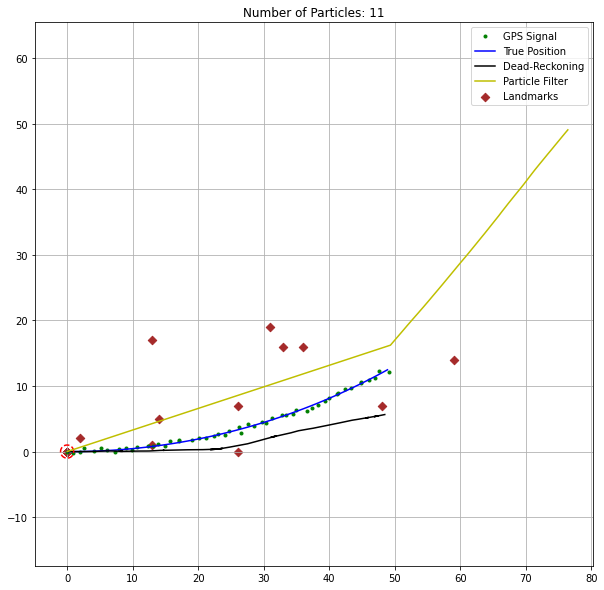

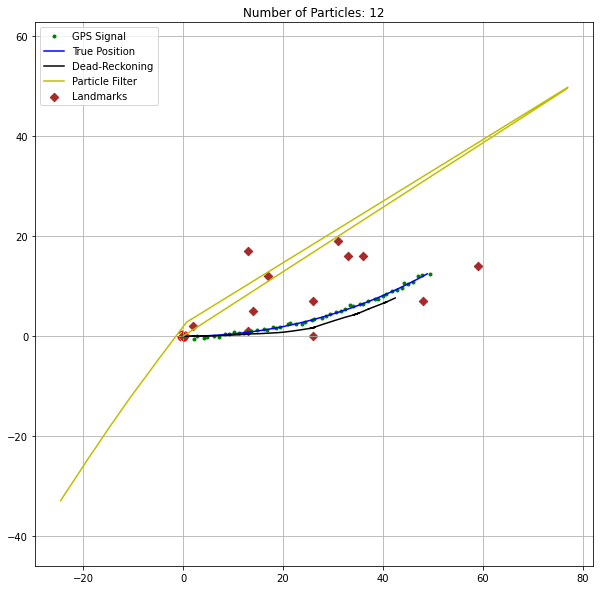

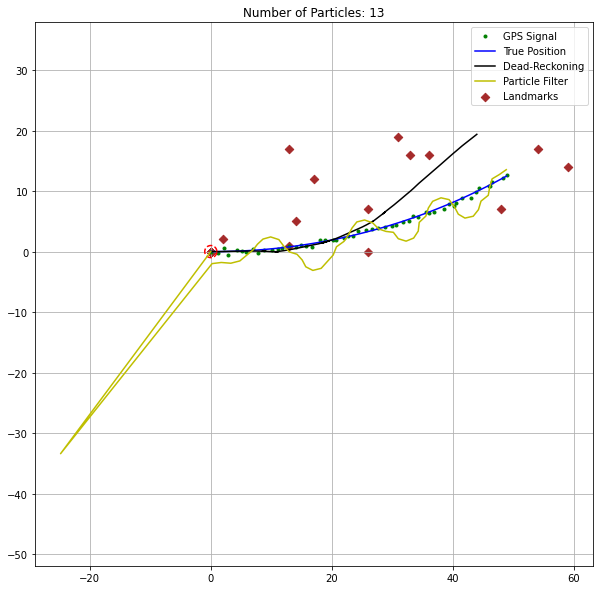

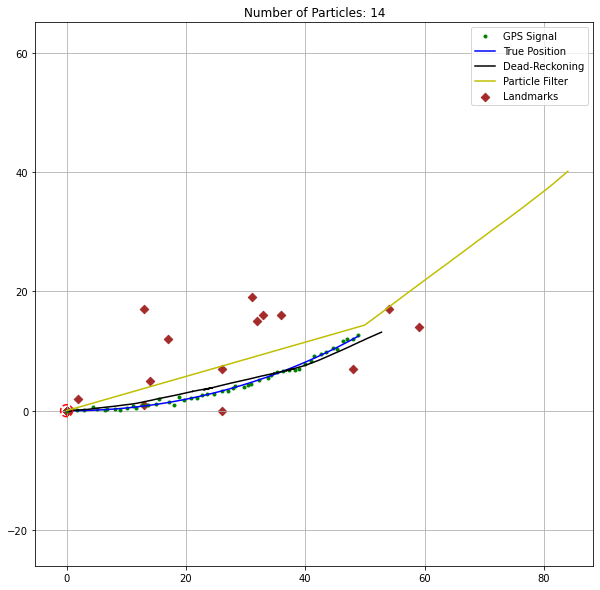

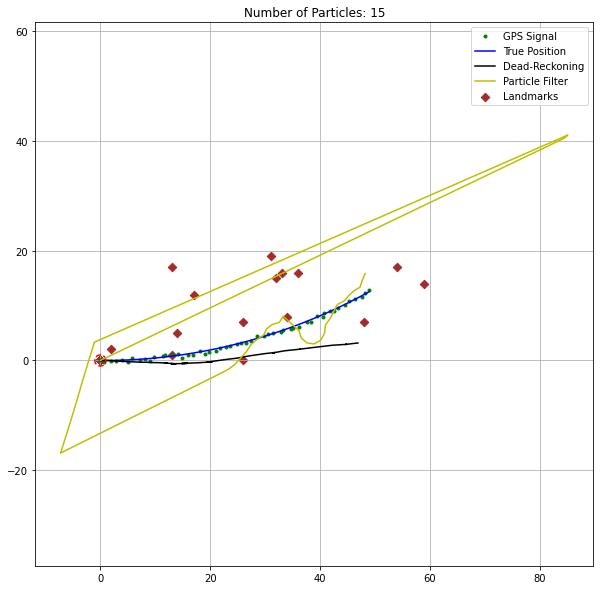

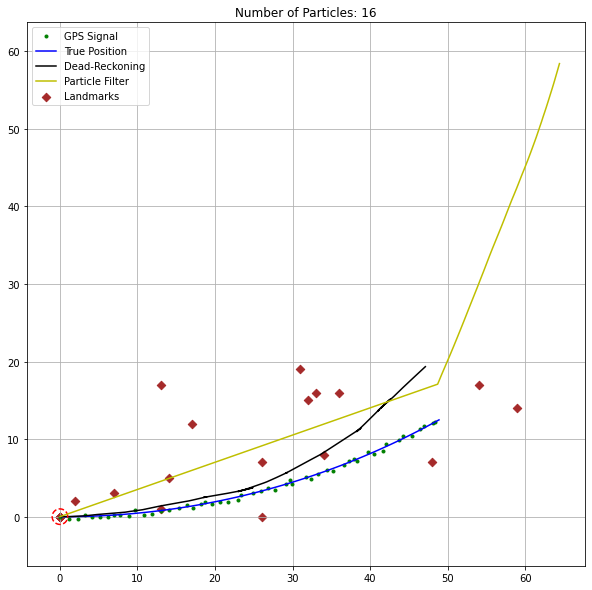

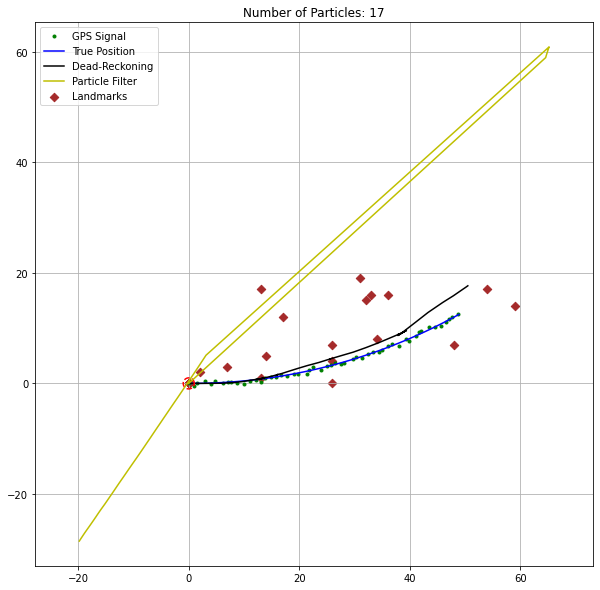

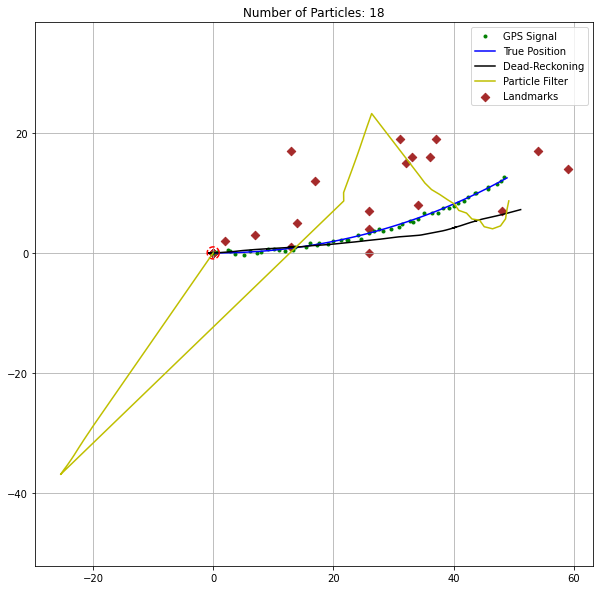

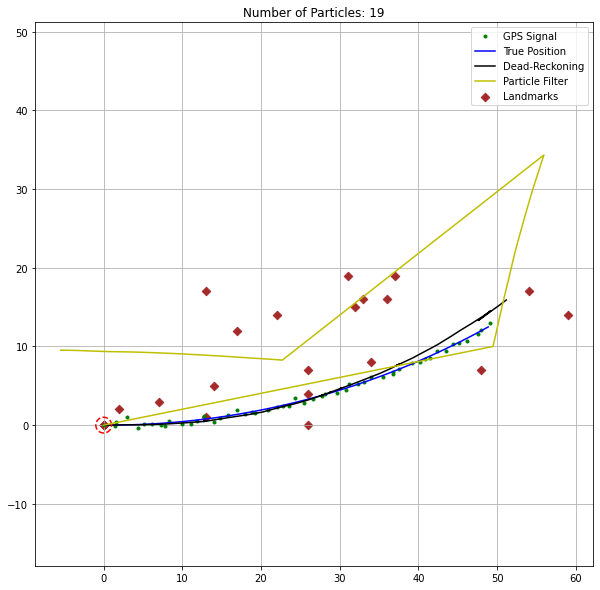

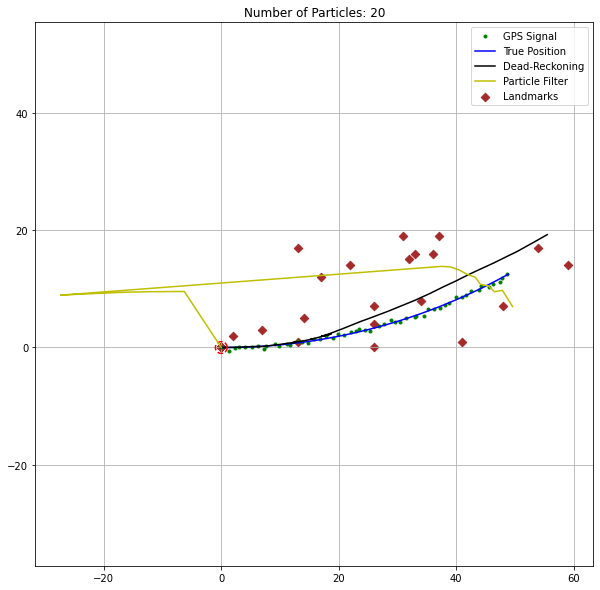

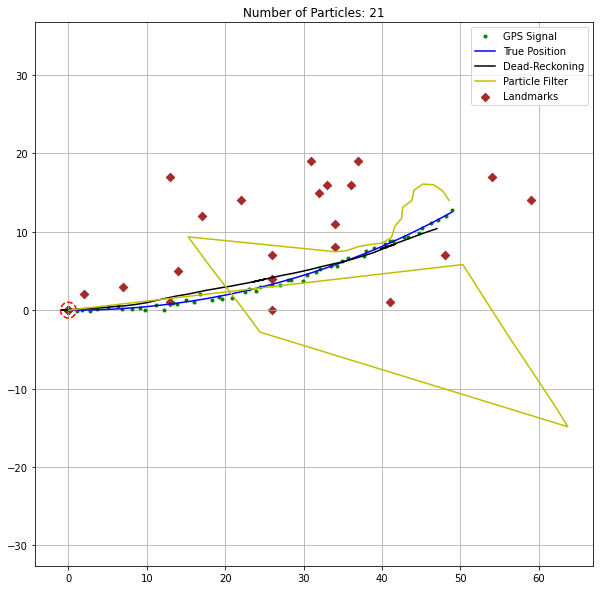

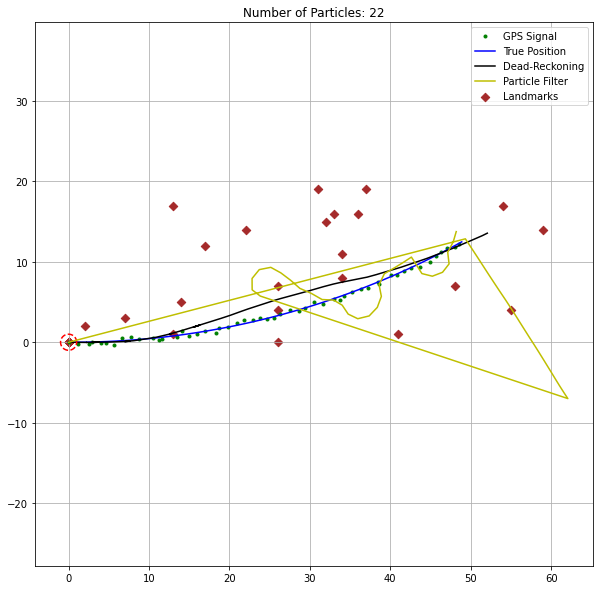

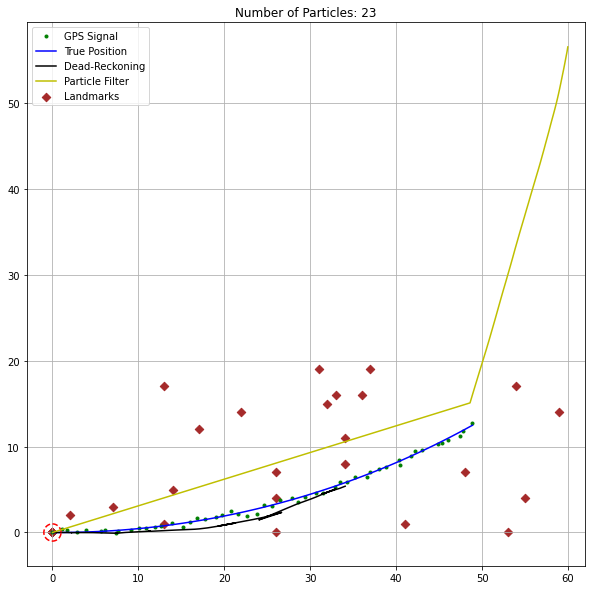

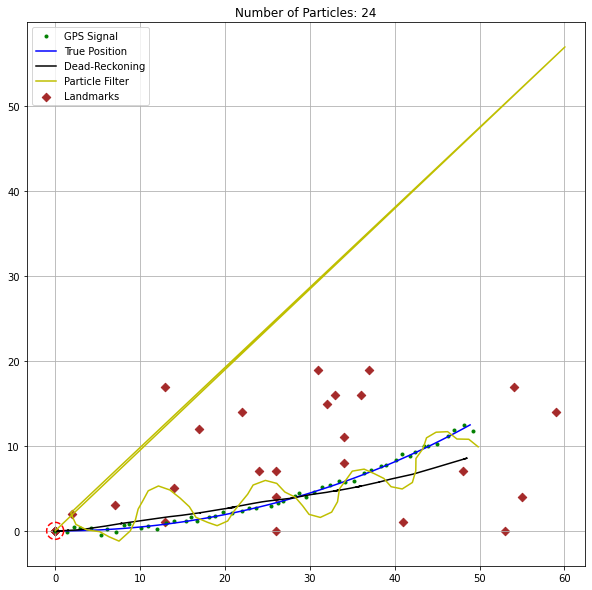

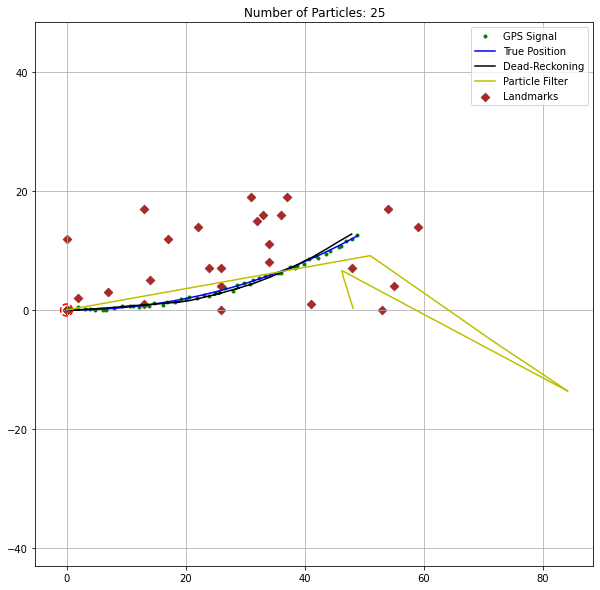

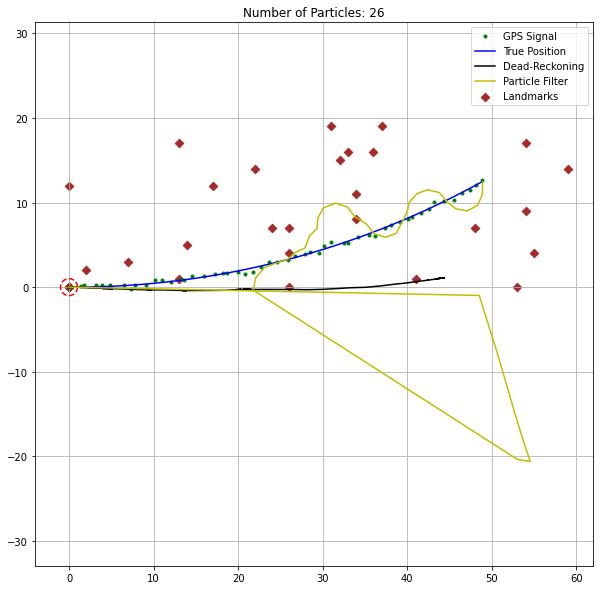

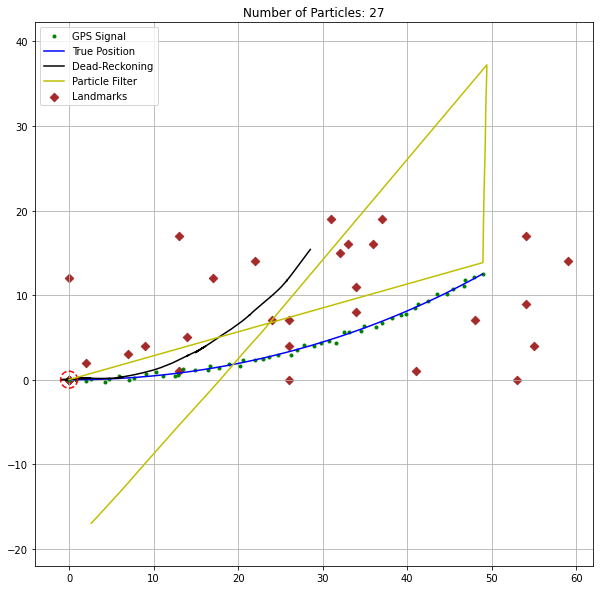

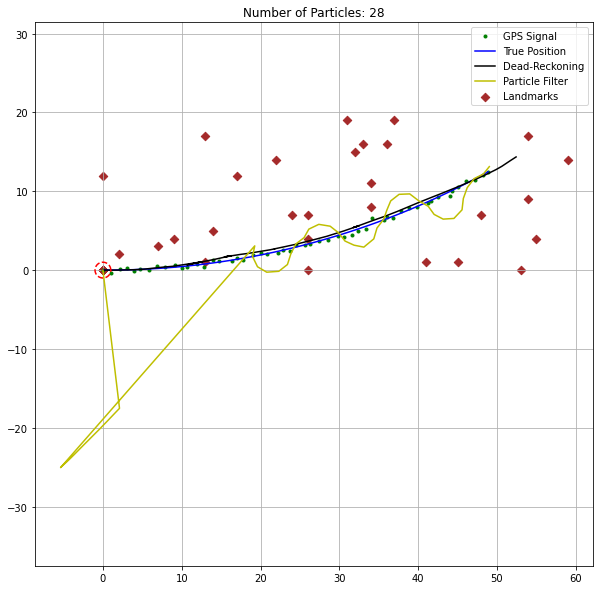

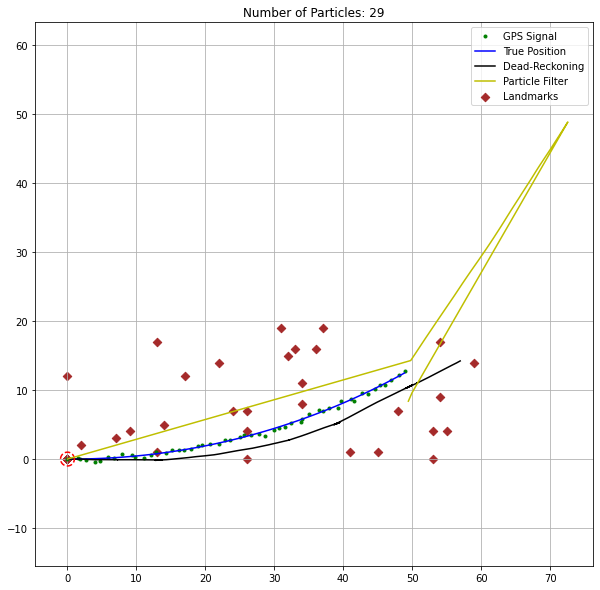

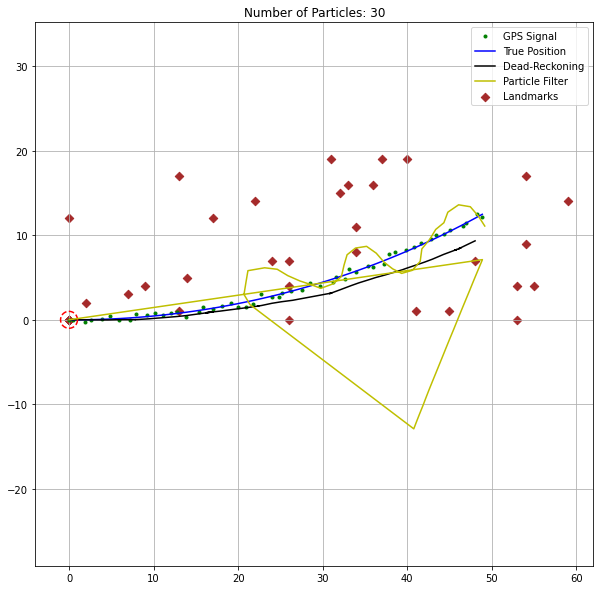

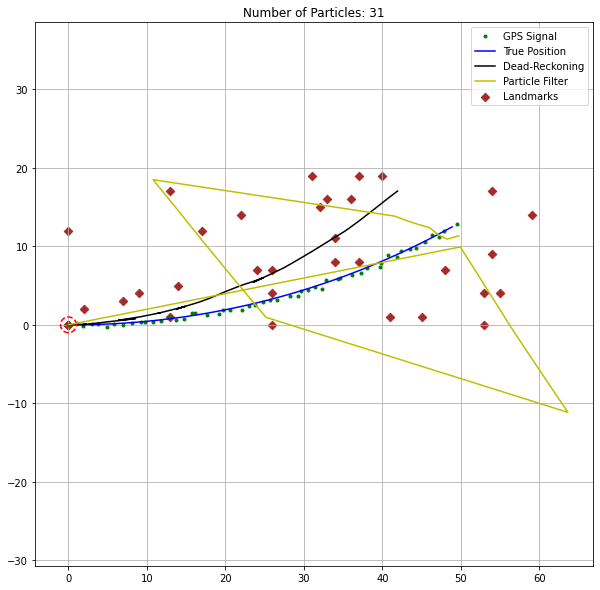

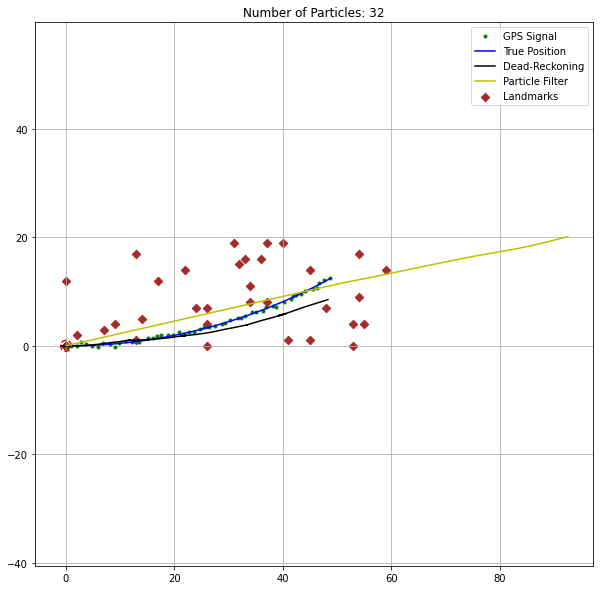

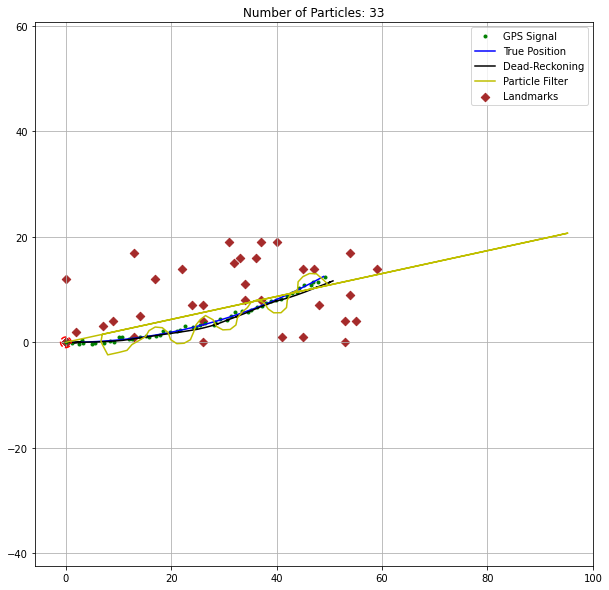

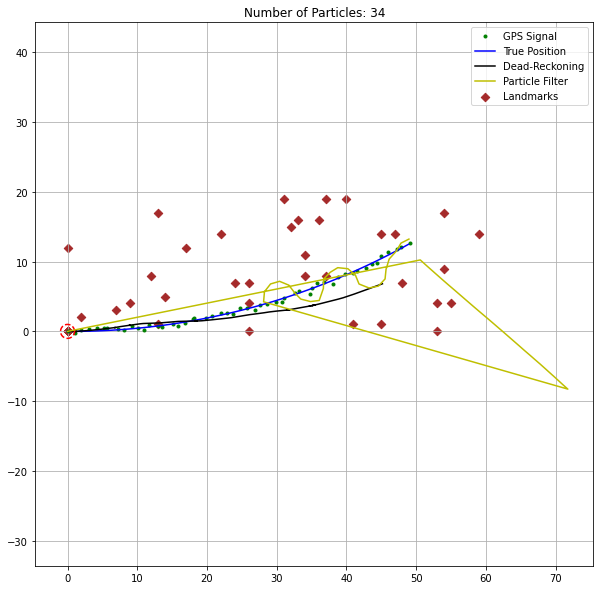

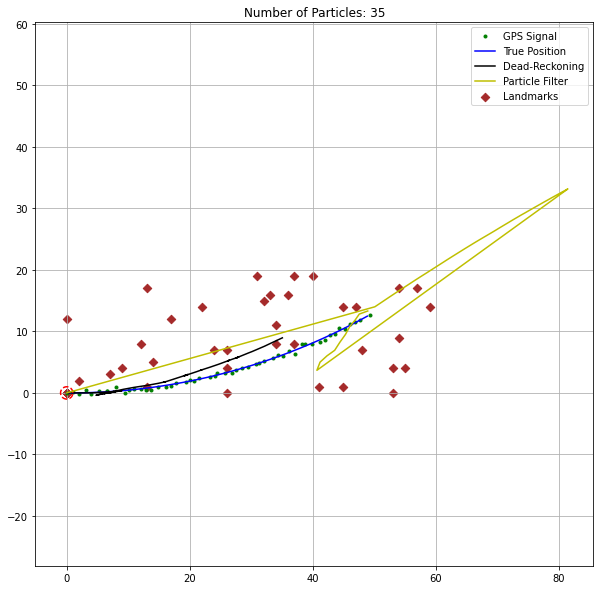

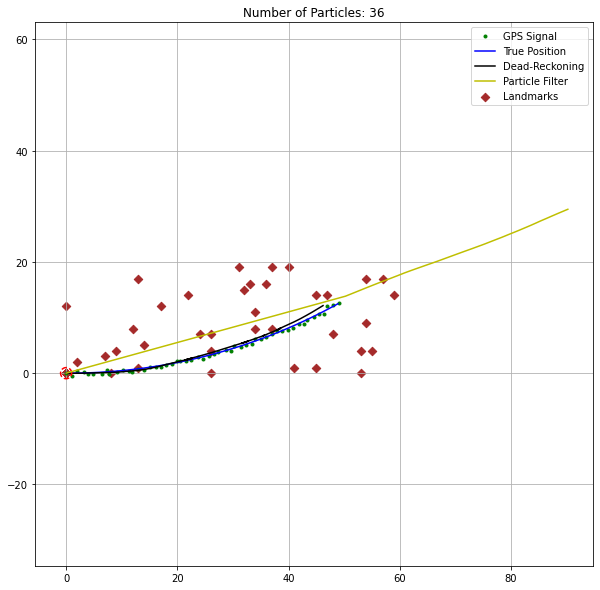

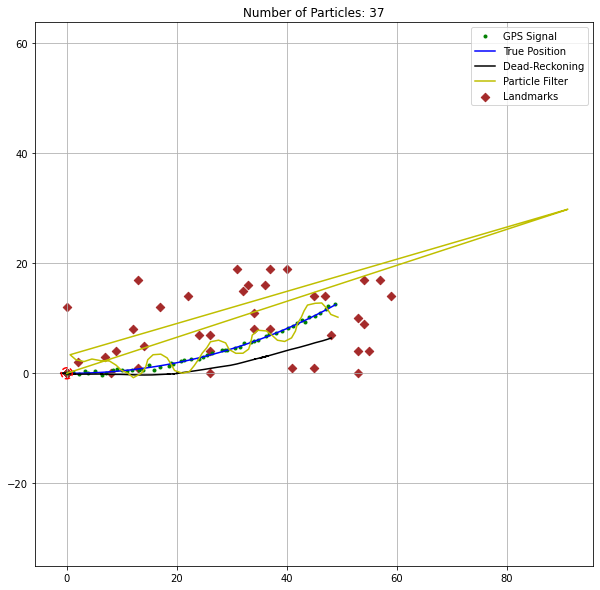

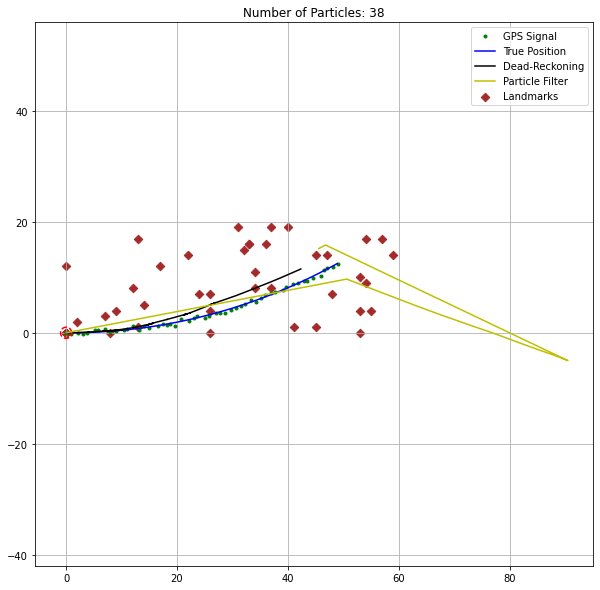

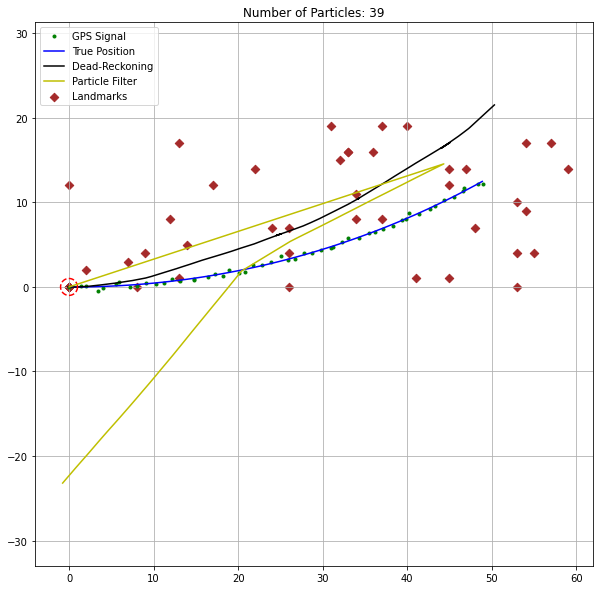

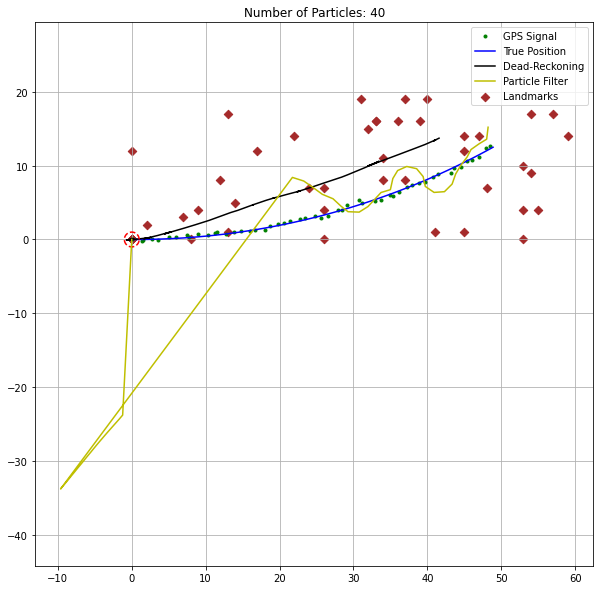

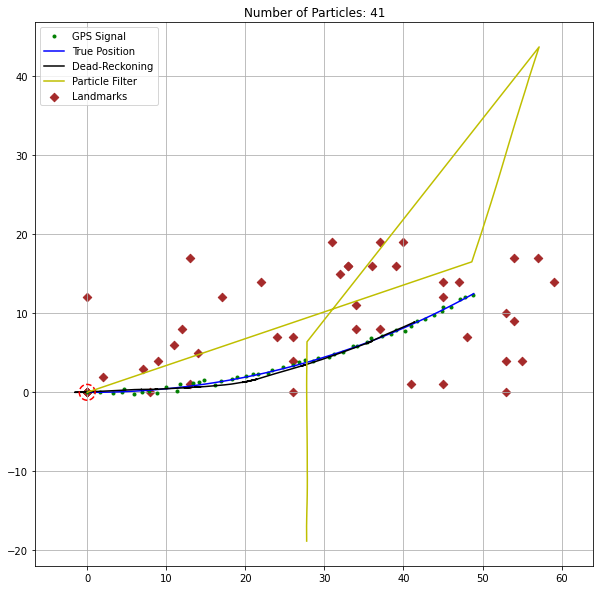

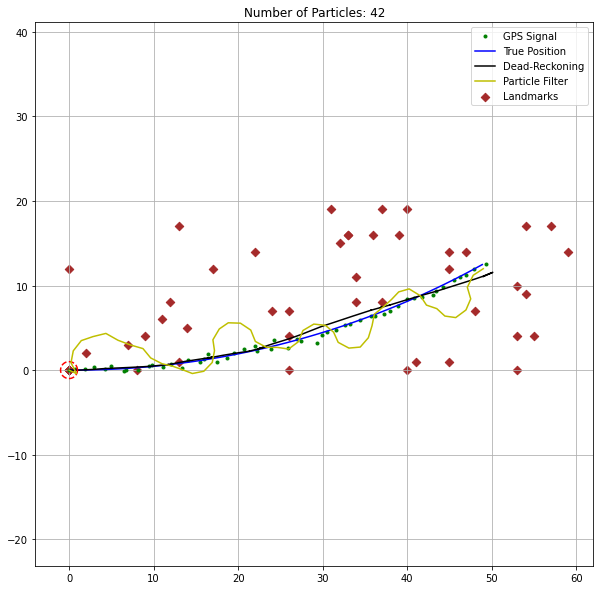

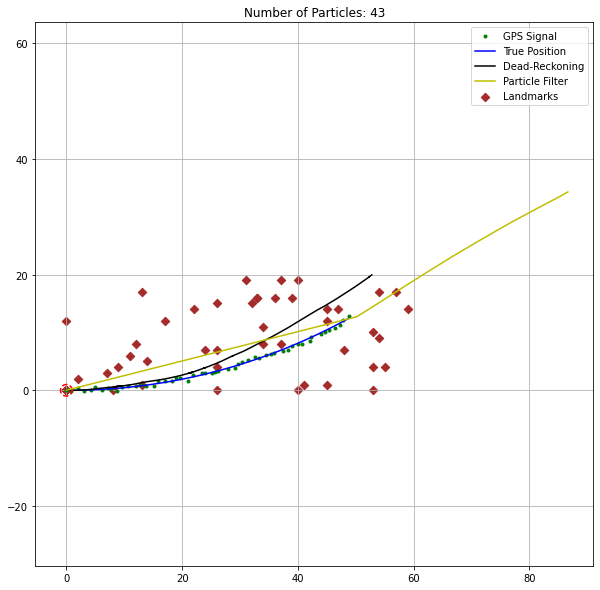

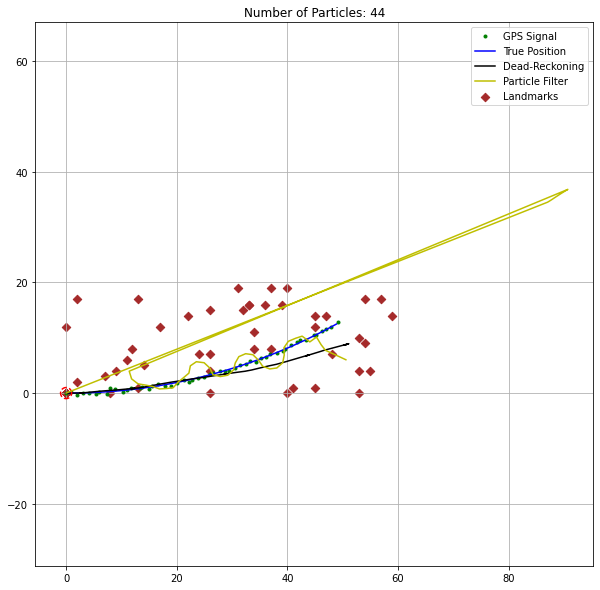

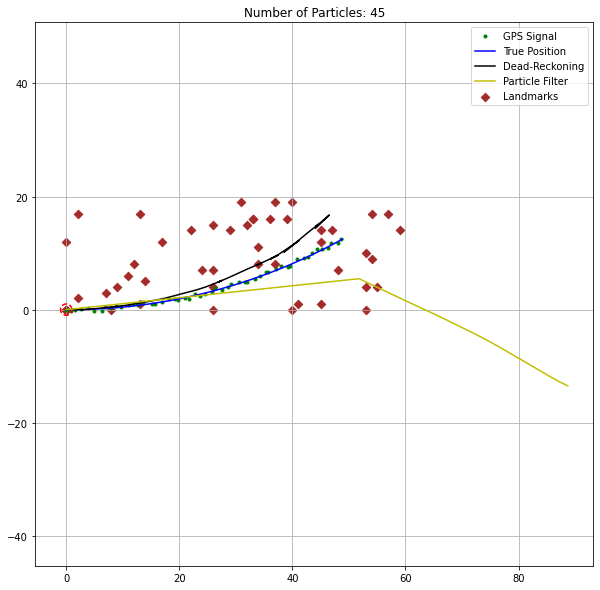

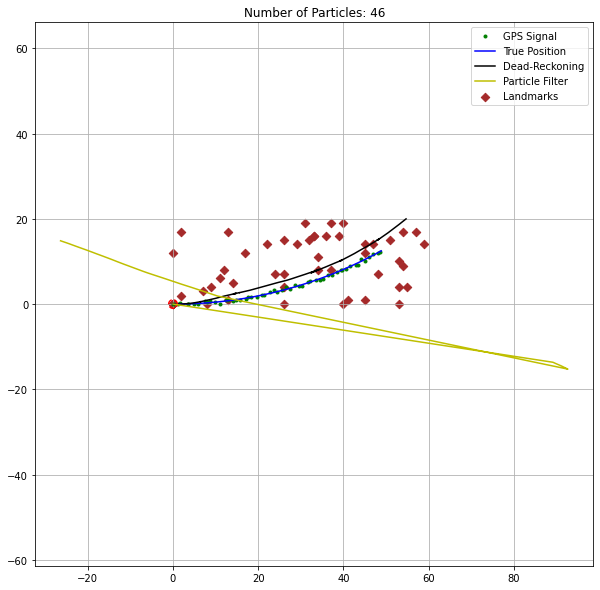

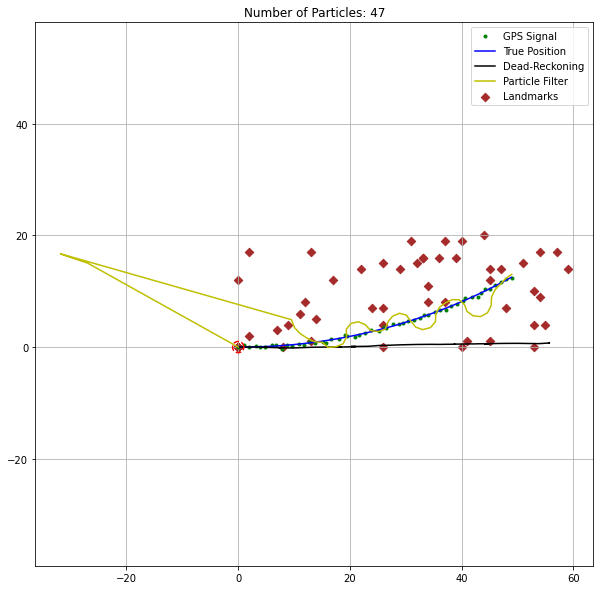

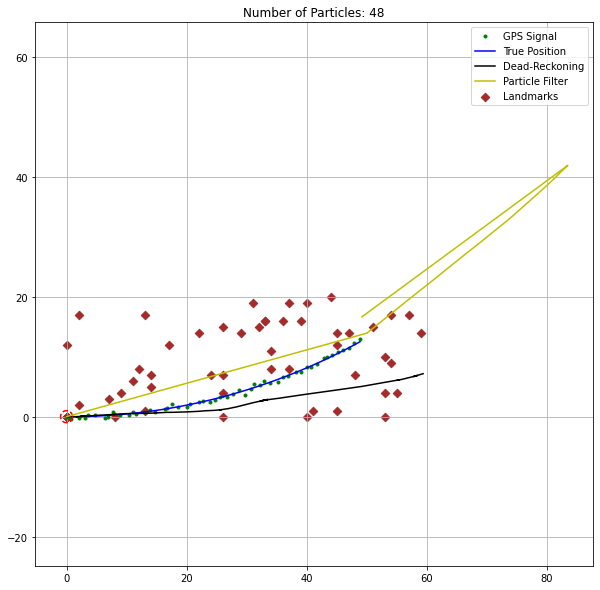

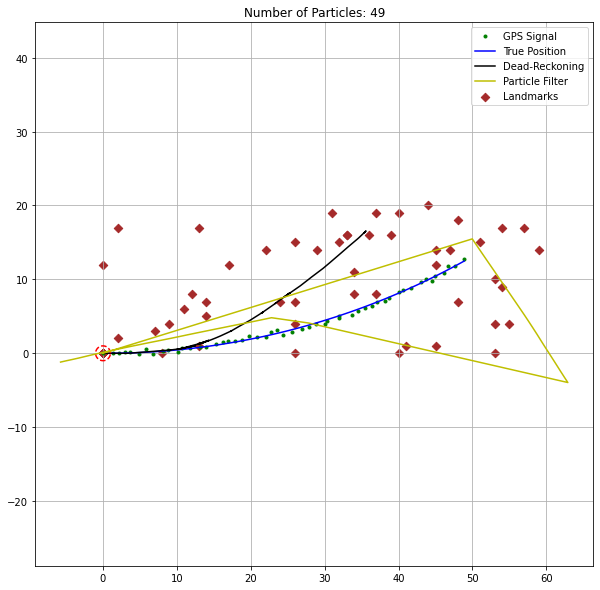

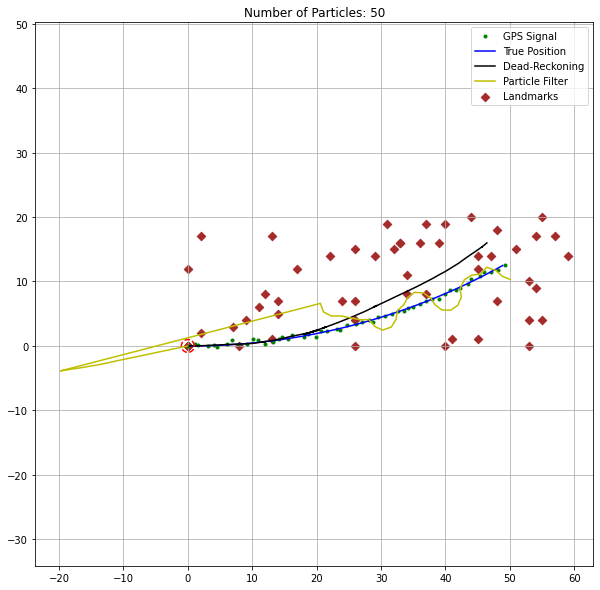

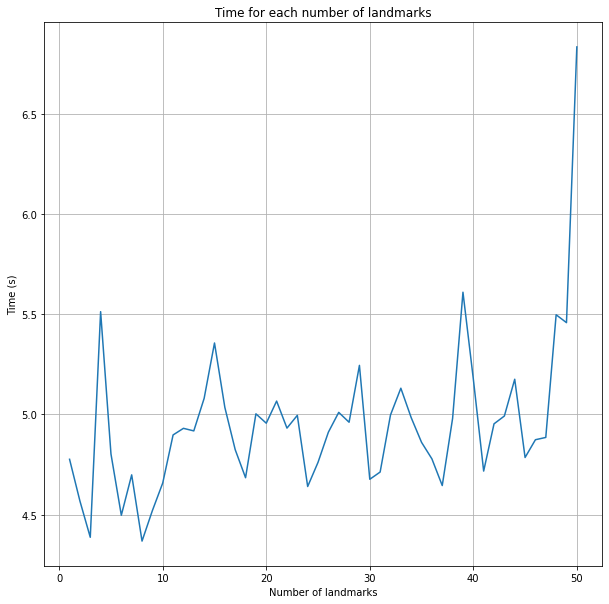

In [108]:
test_number_particles()

### Comparação de resultados dos filtros com a realidade

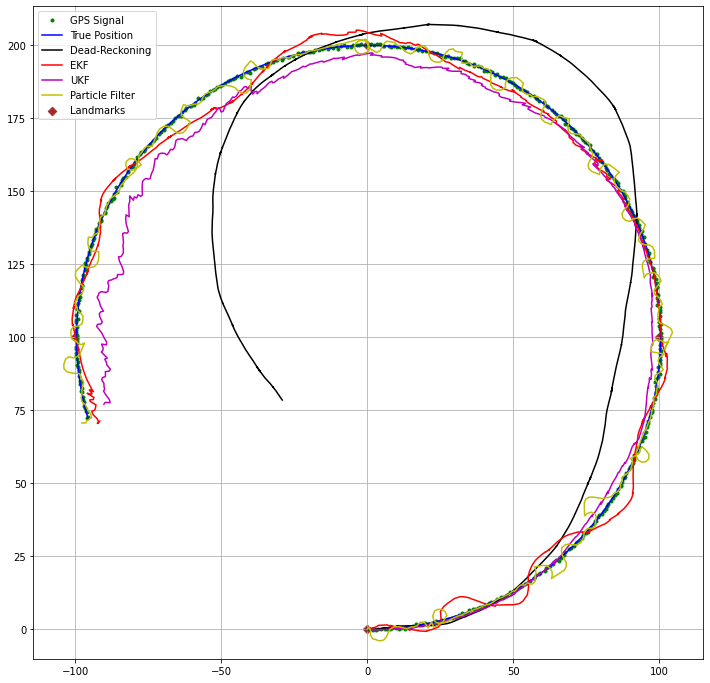

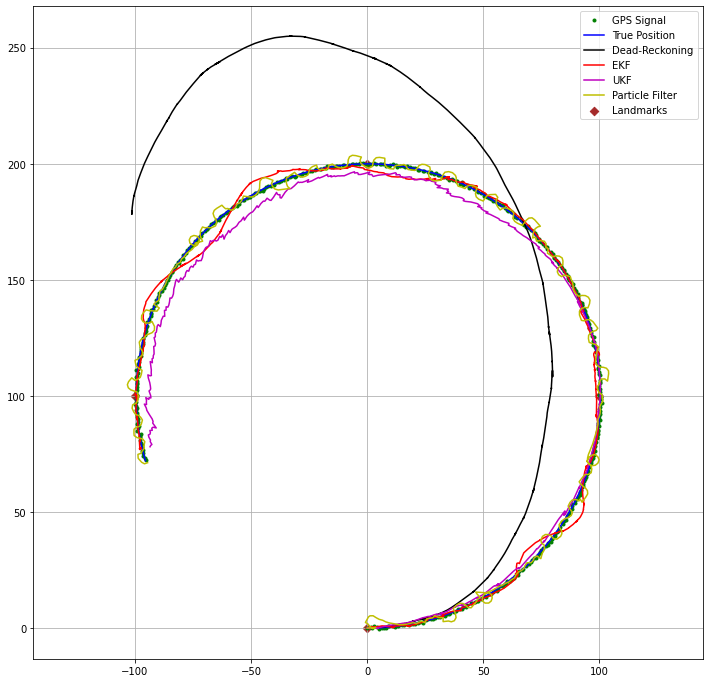

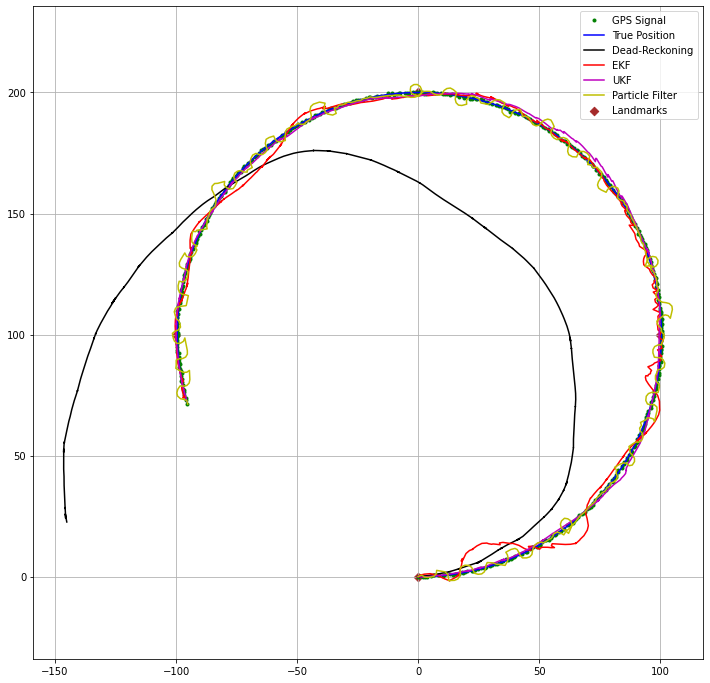

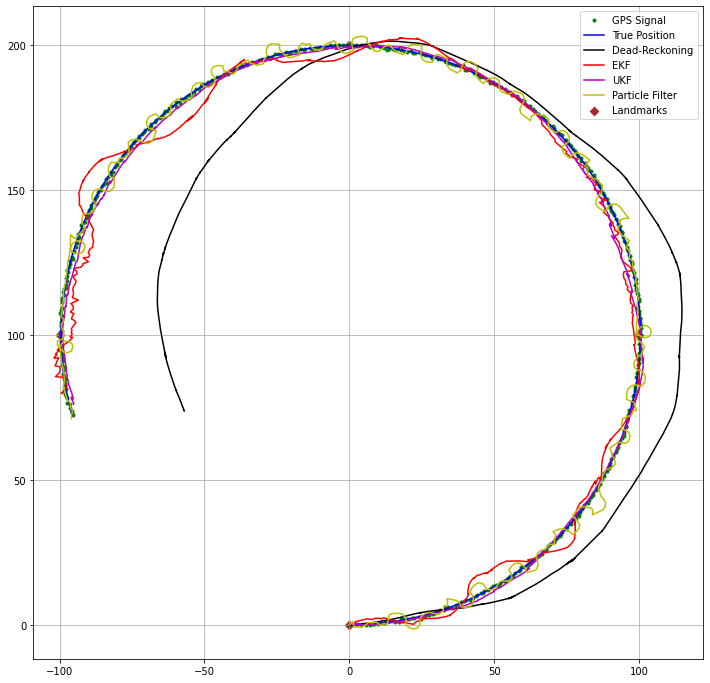

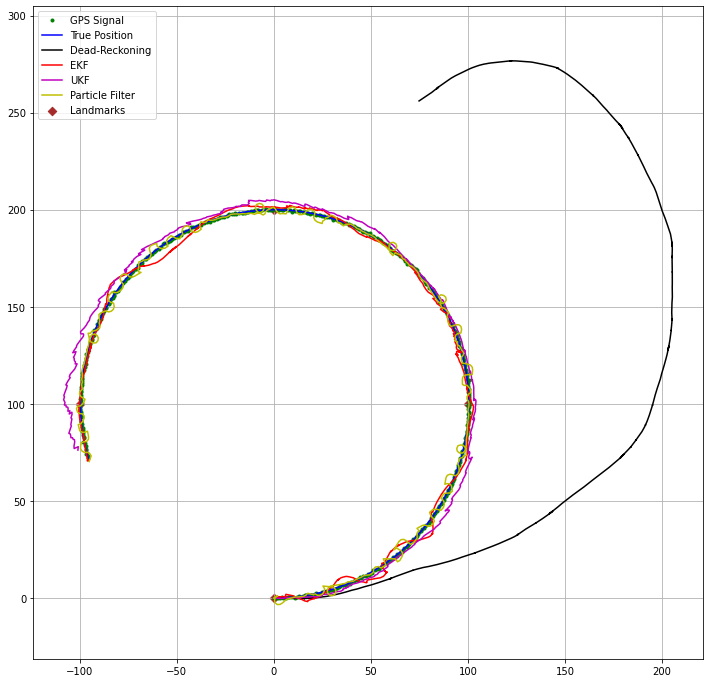

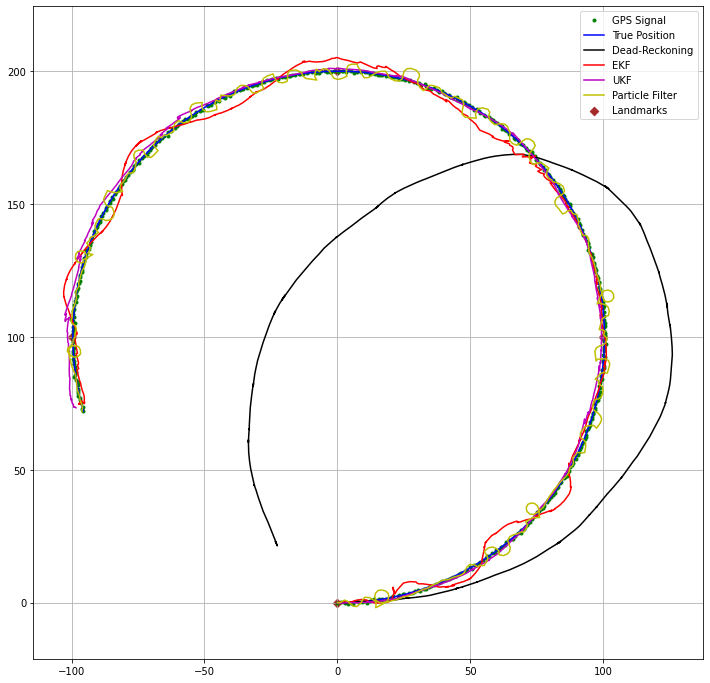

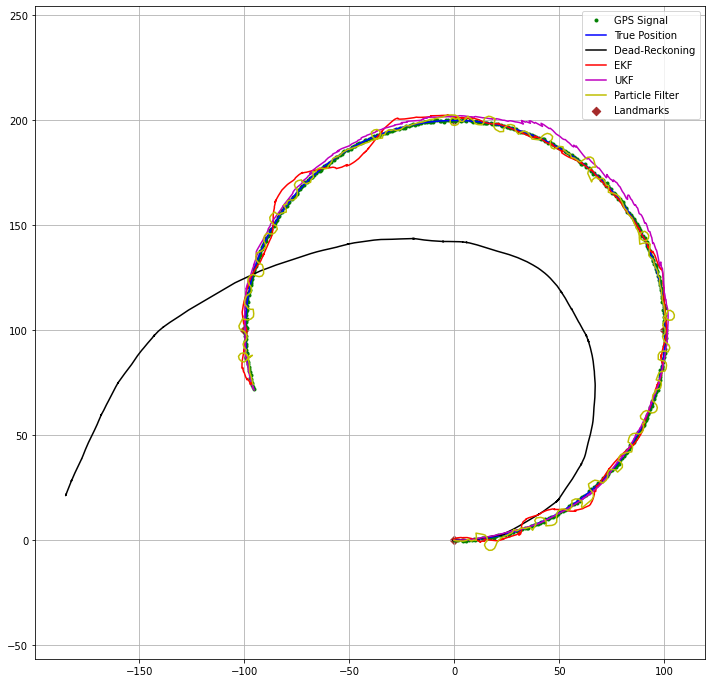

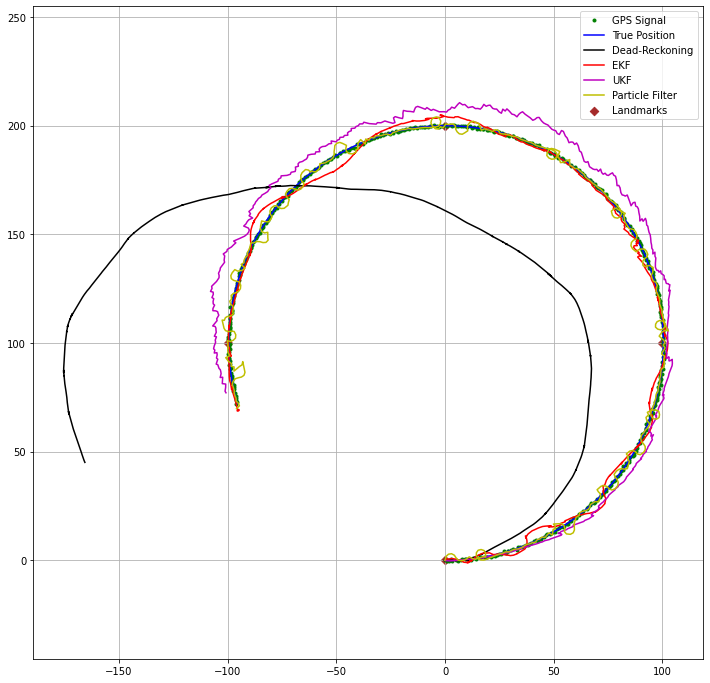

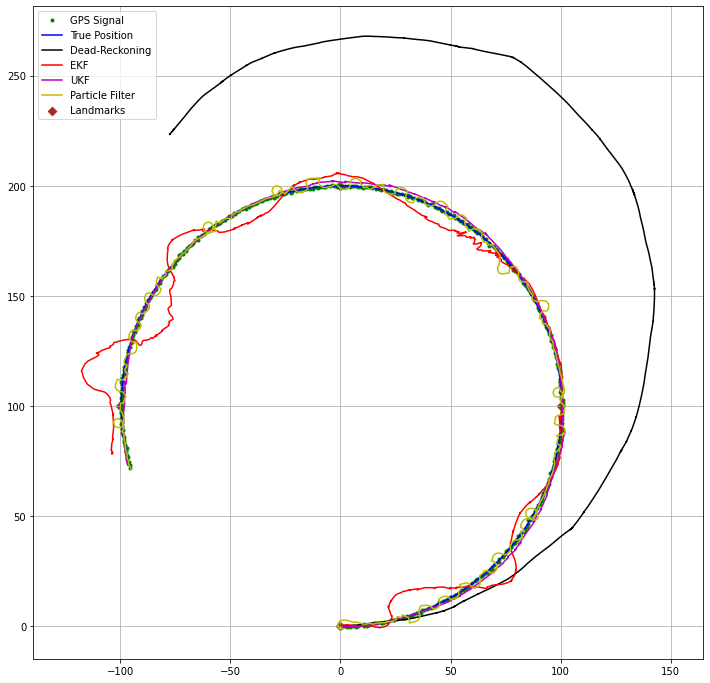

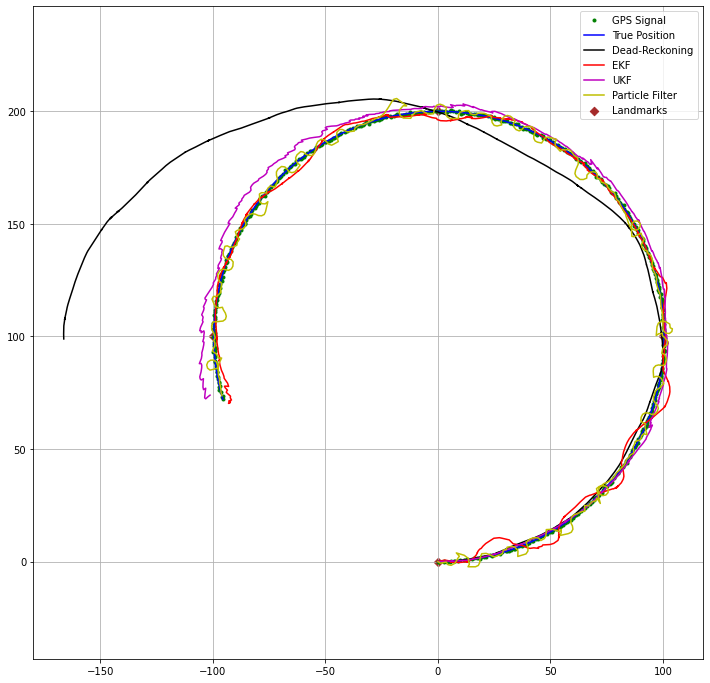

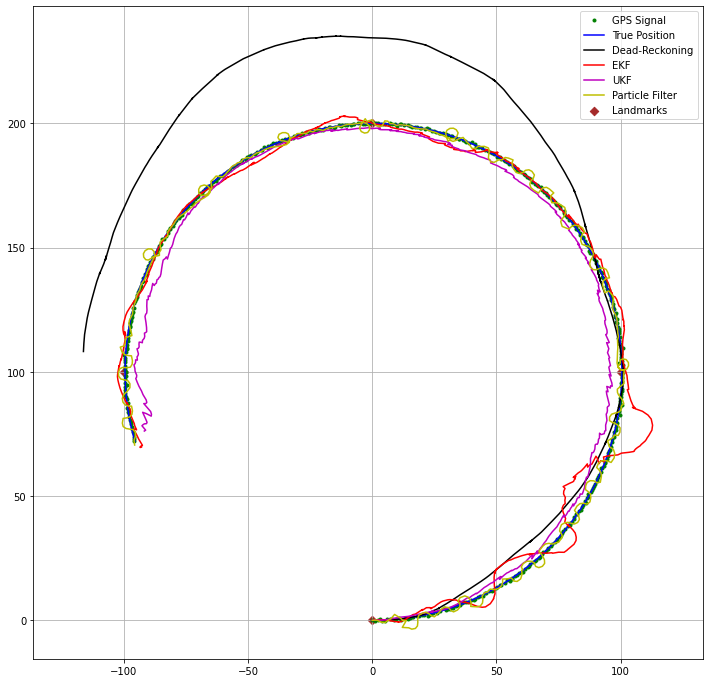

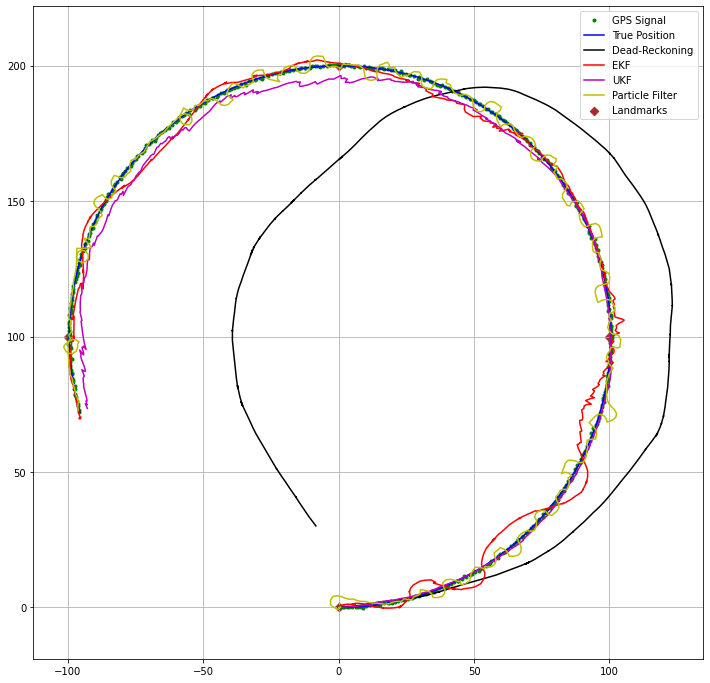

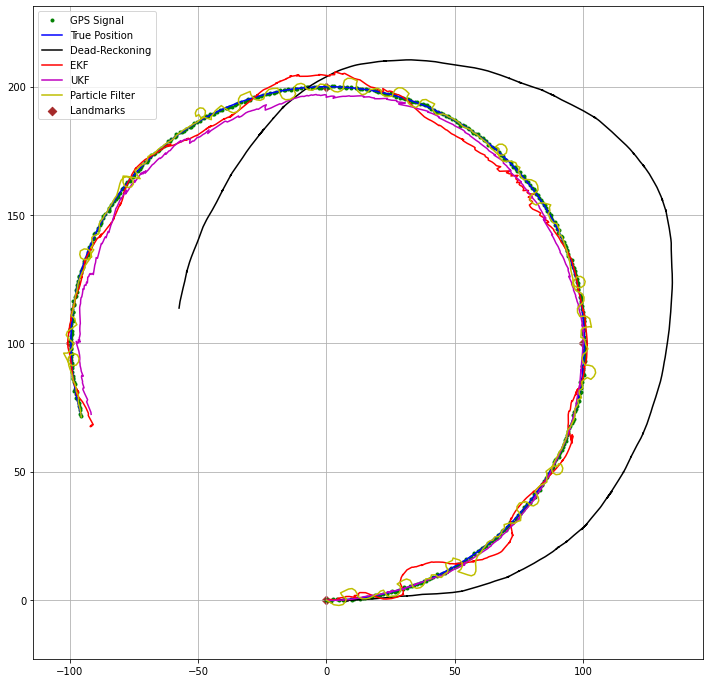

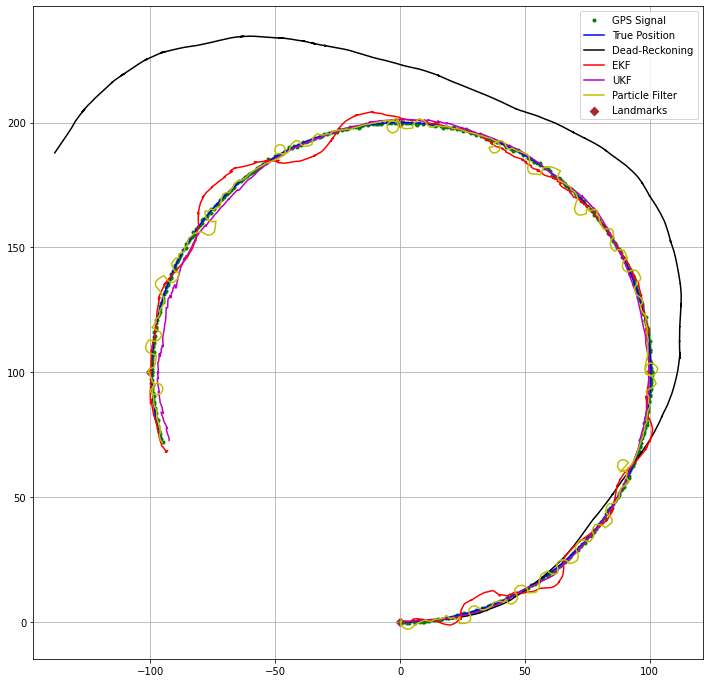

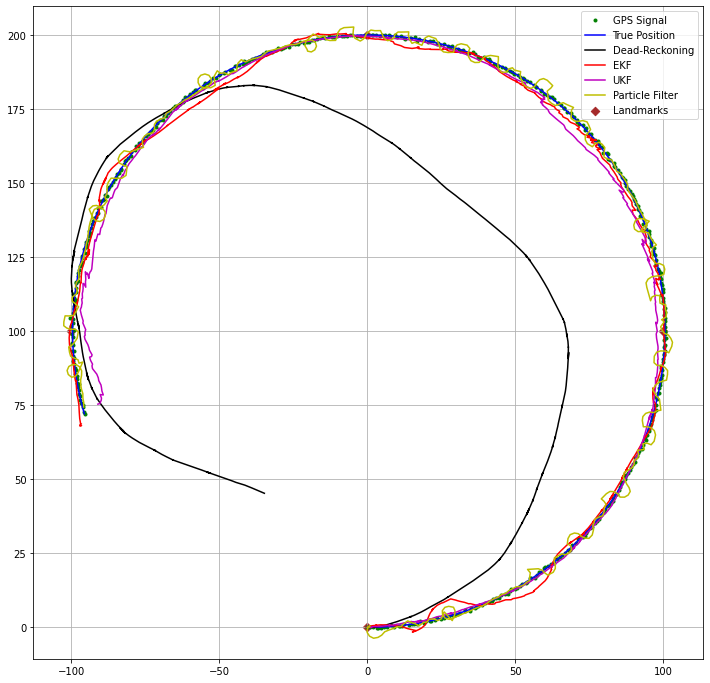

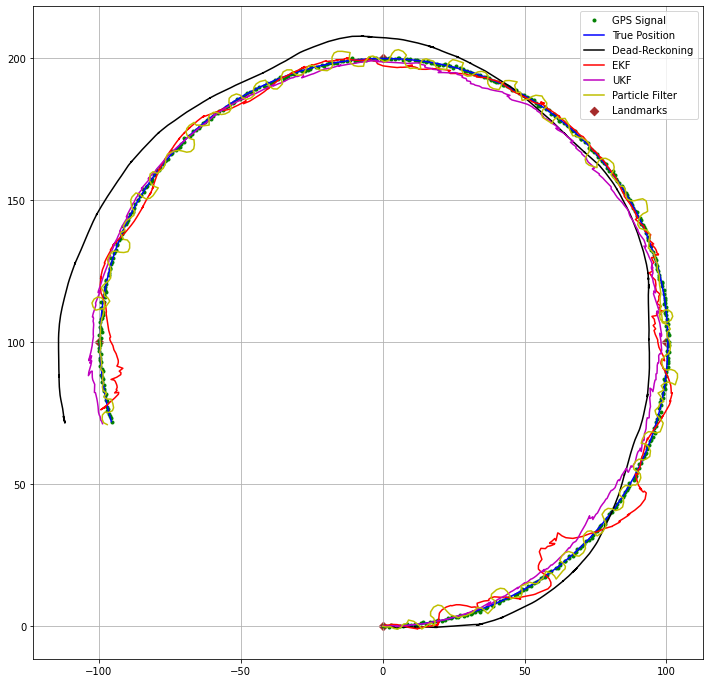

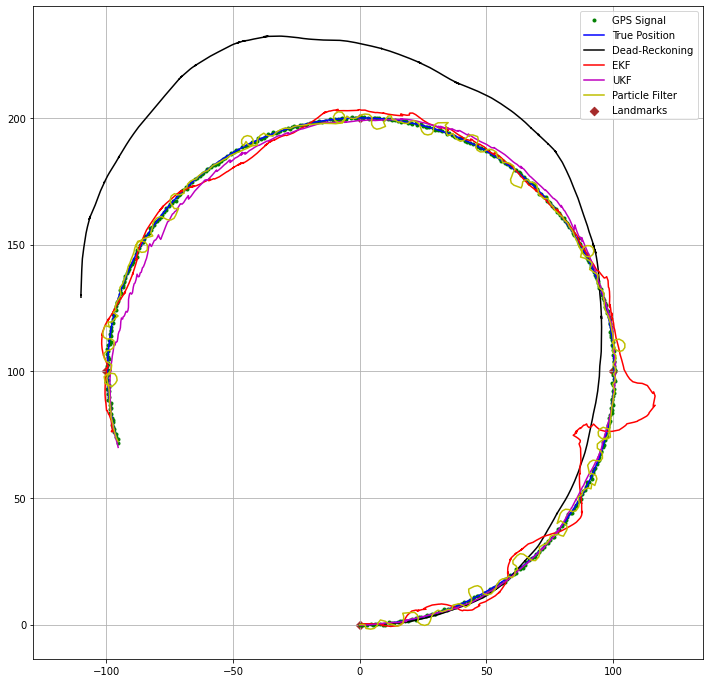

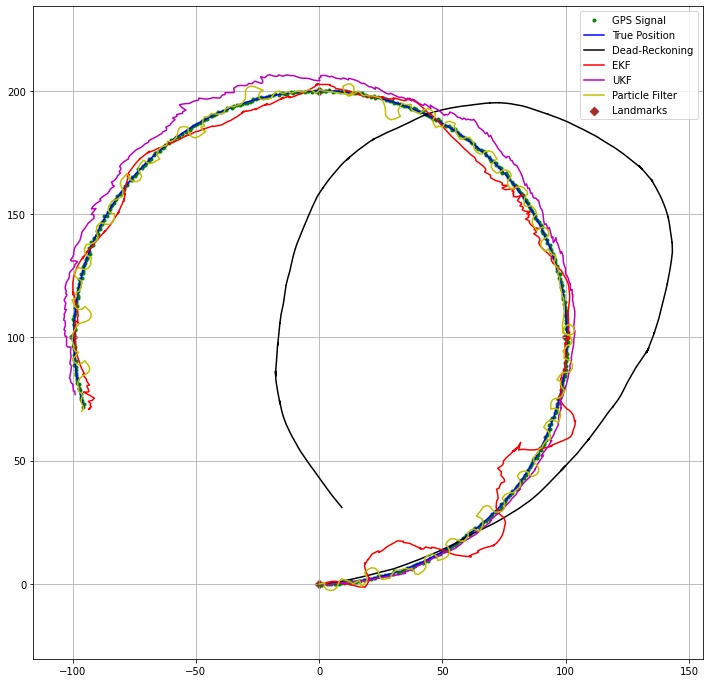

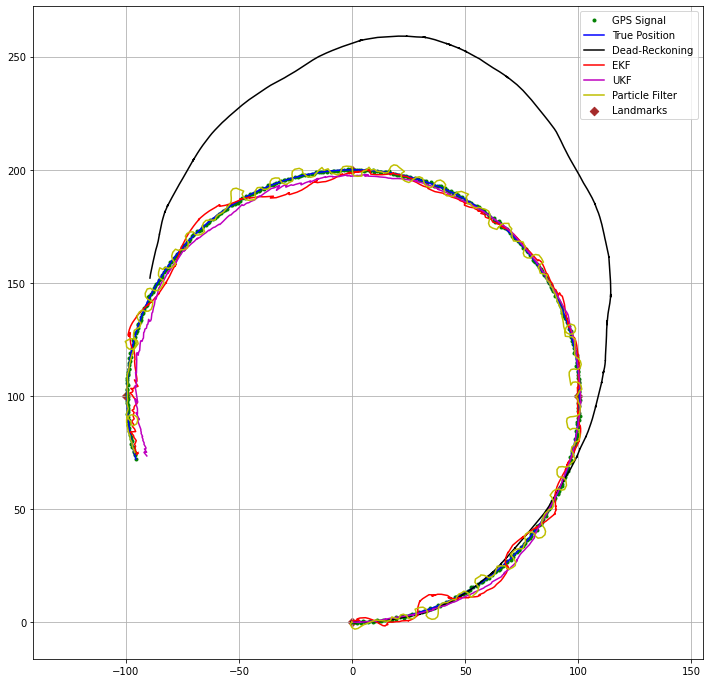

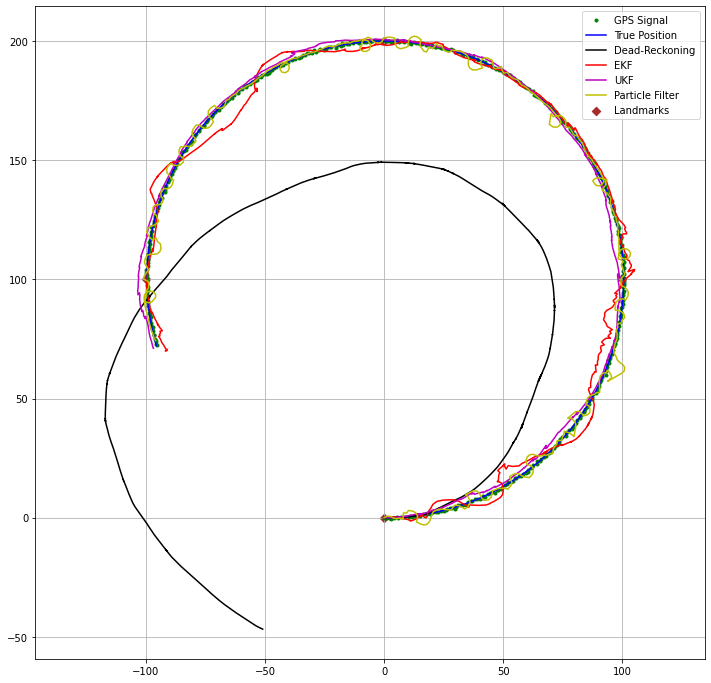

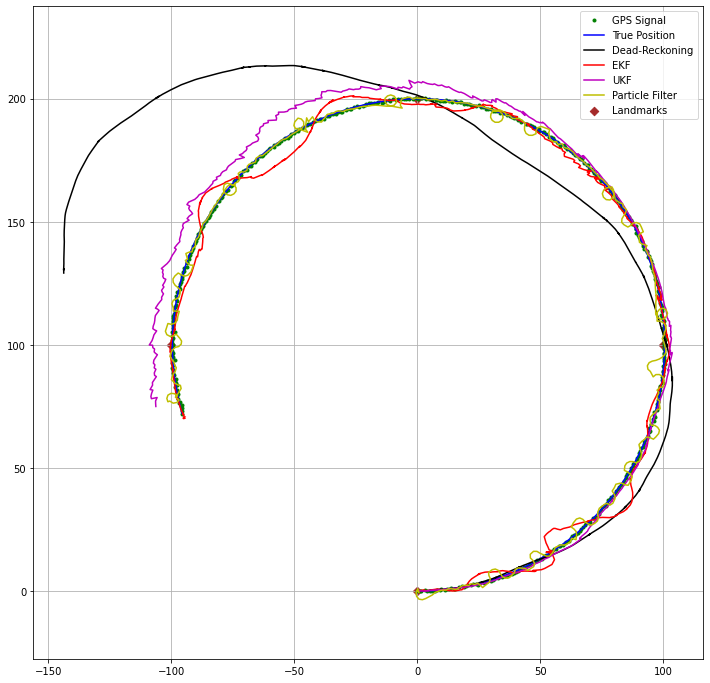

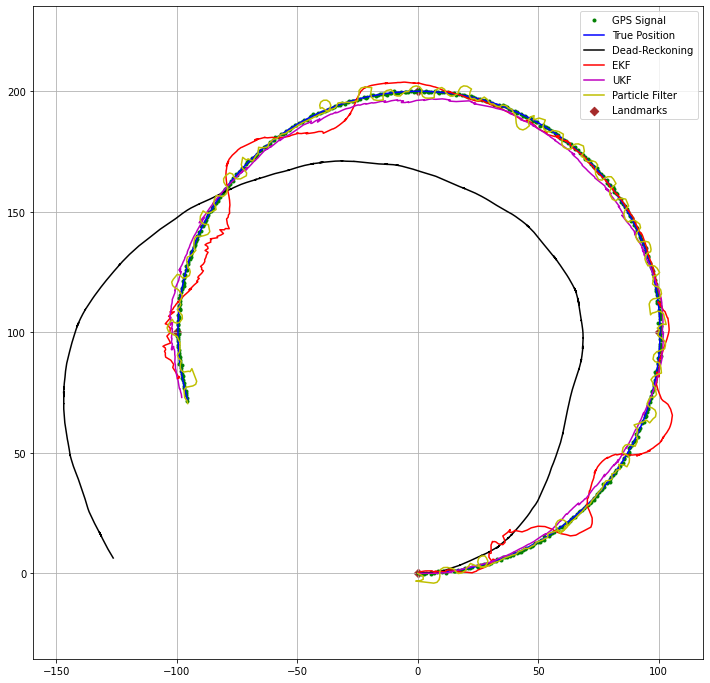

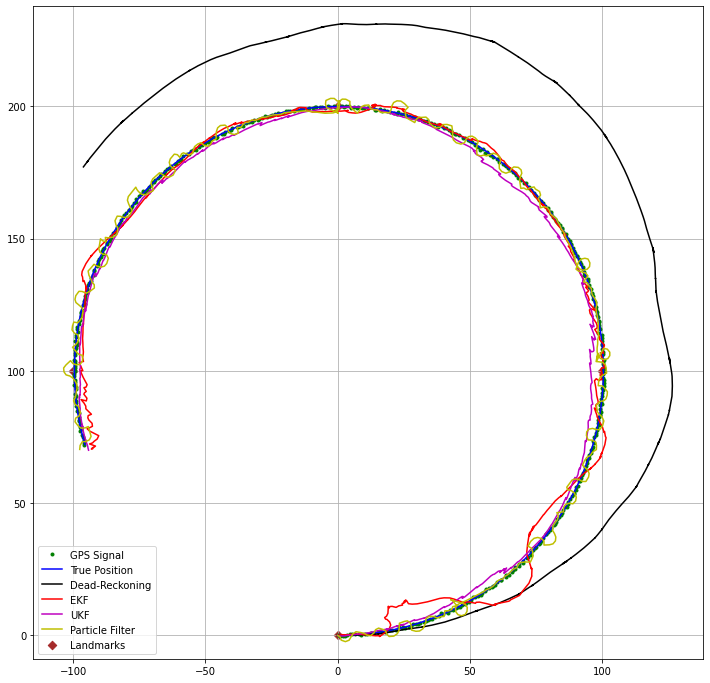

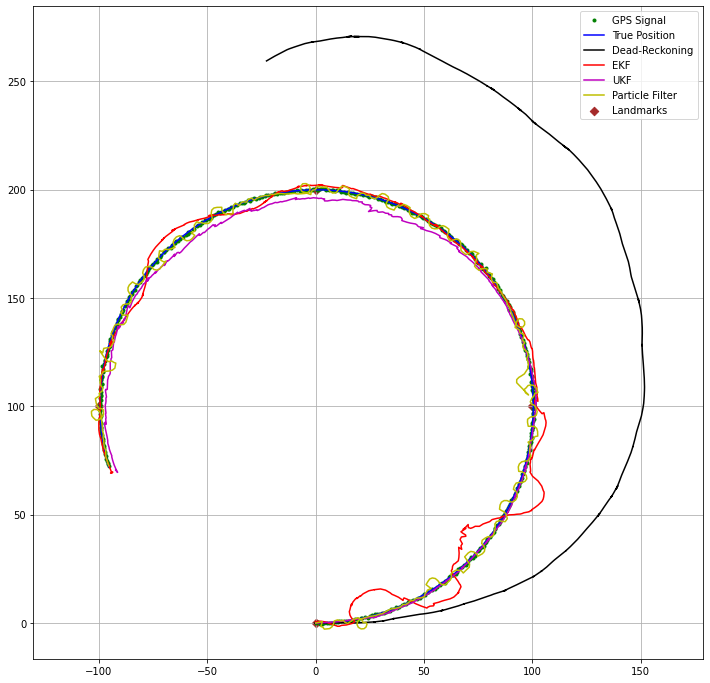

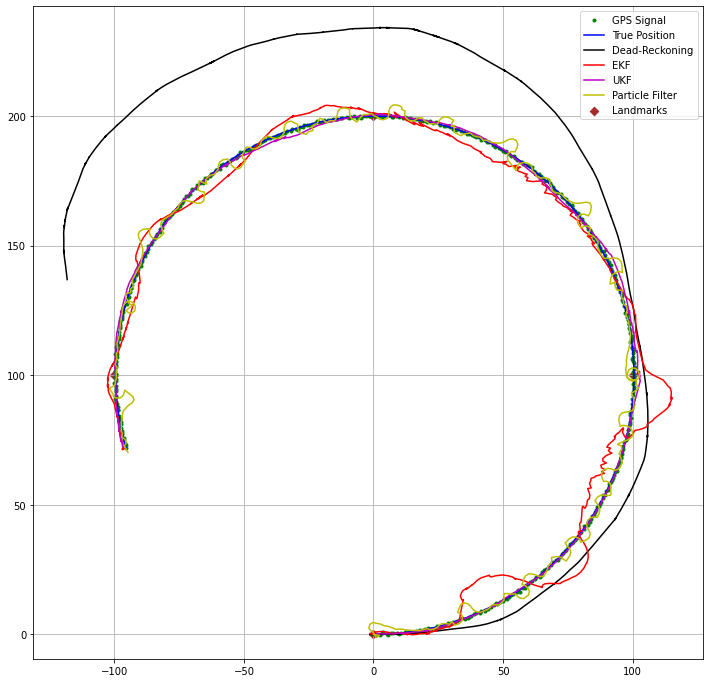

In [101]:
mse_dr = []
rmse_dr = []
r2_dr = []

mse_ekf = []
rmse_ekf = []
r2_ekf = []

mse_ukf = []
rmse_ukf = []
r2_ukf = []

mse_pf = []
rmse_pf = []
r2_pf = []

for i in range(25):
    # True position, dead-reckoning, ekf, ukf, particle filter
    mse_hxDR, rmse_hxDR, r2_hxDR, mse_hxEst, rmse_hxEst, r2_hxEst, mse_hxEst_2, rmse_hxEst_2, r2_hxEst_2, mse_hxmu, rmse_hxmu, r2_hxmu = main()

    mse_dr.append(mse_hxDR)
    rmse_dr.append(rmse_hxDR)
    r2_dr.append(r2_hxDR)

    mse_ekf.append(mse_hxEst)
    rmse_ekf.append(rmse_hxEst)
    r2_ekf.append(r2_hxEst)

    mse_ukf.append(mse_hxEst_2)
    rmse_ukf.append(rmse_hxEst_2)
    r2_ukf.append(r2_hxEst_2)

    mse_pf.append(mse_hxmu)
    rmse_pf.append(rmse_hxmu)
    r2_pf.append(r2_hxmu)
    
mse_dr_mean = np.average(mse_dr)
mse_dr_std = np.std(mse_dr)
rmse_dr_mean = np.average(rmse_dr)
rmse_dr_std = np.std(rmse_dr)
r2_dr_mean = np.average(r2_dr)
r2_dr_std = np.std(r2_dr)

mse_ekf_mean = np.average(mse_ekf)
mse_ekf_std = np.std(mse_ekf)
rmse_ekf_mean = np.average(rmse_ekf)
rmse_ekf_std = np.std(rmse_ekf)
r2_ekf_mean = np.average(r2_ekf)
r2_ekf_std = np.std(r2_ekf)

mse_ukf_mean = np.average(mse_ukf)
mse_ukf_std = np.std(mse_ukf)
rmse_ukf_mean = np.average(rmse_ukf)
rmse_ukf_std = np.std(rmse_ukf)
r2_ukf_mean = np.average(r2_ukf)
r2_ukf_std = np.std(r2_ukf)

mse_pf_mean = np.average(mse_pf)
mse_pf_std = np.std(mse_pf)
rmse_pf_mean = np.average(rmse_pf)
rmse_pf_std = np.std(rmse_pf)
r2_pf_mean = np.average(r2_pf)
r2_pf_std = np.std(r2_pf)
    
metrics = pd.DataFrame(
    np.array([[mse_dr_mean, mse_dr_std, rmse_dr_mean, rmse_dr_std, r2_dr_mean, r2_dr_std],
              [mse_ekf_mean, mse_ekf_std, rmse_ekf_mean, rmse_ekf_std, r2_ekf_mean, r2_ekf_std],
              [mse_ukf_mean, mse_ukf_std, rmse_ukf_mean, rmse_ukf_std, r2_ukf_mean, r2_ukf_std],
              [mse_pf_mean, mse_dr_std, rmse_pf_mean, rmse_pf_std, r2_pf_mean, r2_pf_std]]),
    columns=[
        "MSE_mean",
        "MSE_std",
        "RMSE_mean",
        "RMSE_std",
        "R^2_mean",
        "R^2_std"
    ],
    index=[
        "Dead-Reckoning",
        "EKF",
        "UKF",
        "Particle Filter"
    ]
)

In [102]:
display(metrics)

MSE_mean      MSE_std  RMSE_mean   RMSE_std  R^2_mean  \
Dead-Reckoning   2219.792800  2950.916745  39.369272  22.695863  0.533838   
EKF                 9.310209     5.498613   2.933981   0.808973  0.998002   
UKF                 7.159836     6.057461   2.492470   0.918983  0.998478   
Particle Filter     4.702890  2950.916745   2.156454   0.135714  0.998993   

                  R^2_std  
Dead-Reckoning   0.605040  
EKF              0.001179  
UKF              0.001298  
Particle Filter  0.000121

<p>Relativamente aos valores de MSE e RMSE, quanto mais próximos de zero, mais próximo da realidade é o modelo.</p>
<p>Para obter os valores de MSE e RMSE, foram testados 25 vezes cada algoritmo, obtendo assim 25 valores para cada algoritmo e métrica. O resultado final é a média e o desvio padrão desses mesmos valores.</p>
<p><b>Conclusões</b>:</p>
<ul>
    <li>O algoritmo com os valores mais baixos de MSE e RMSE é o Particle Filter, contudo, conseguimos perceber que é instável (pelo MSE_std).</li>
    <li>O EKF, o UKF e Particle Filter têm resultados bastante próximos da realidade (R^2).</li>
    <li>Sem sombra de dúvidas, o pior deles todos é o Dead-Reckoning (vemos pelas métricas todas).</li>
    <li>Os algoritmos mais estáveis são o EKF e UKF pois o MSE_std tem os valores mais baixos.</li>
</ul>